In [1]:
#Memorial Hermann Sugar Land Hospital Surgical Tool Analysis

StatementMeta(, feee0914-270a-42af-9555-54386589a685, 3, Finished, Available, Finished)

In [2]:
from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder.appName("Combine DataFrames").getOrCreate()

StatementMeta(, feee0914-270a-42af-9555-54386589a685, 4, Finished, Available, Finished)

In [3]:
df = spark.read.format("csv").option("header","true").load("Files/Container General Information - Sugar Land.csv")
display(df)

StatementMeta(, feee0914-270a-42af-9555-54386589a685, 5, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, a6a630b8-741d-477a-81d8-336eece7a77f)

In [4]:
df2 = spark.read.format("csv").option("header","true").load("Files/Container Inventory by Location - Sugar Land.csv")
display(df2)

StatementMeta(, feee0914-270a-42af-9555-54386589a685, 6, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, af653963-0499-4aec-b5fc-ebba8ed604ab)

In [5]:
df3 = spark.read.format("csv").option("header","true").load("Files/Container Product Detail - Sugar Land.csv")
display(df3)

StatementMeta(, feee0914-270a-42af-9555-54386589a685, 7, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 3a1f869f-004f-4d33-a8f7-26ae5a48d13a)

In [6]:
df4 = spark.read.format("csv").option("header","true").load("Files/Instrument Items Missing From Container - Sugar Land.csv")
display(df4)

StatementMeta(, feee0914-270a-42af-9555-54386589a685, 8, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, dc41f133-7406-4d7a-aad6-dde8adb33dbd)

In [7]:
df5 = spark.read.format("csv").option("header","true").load("Files/Sterilization Container Level - Sugar Land.csv")
display(df5)

StatementMeta(, feee0914-270a-42af-9555-54386589a685, 9, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 11dec328-9eaa-4e54-84af-6fb3ba944a05)

In [8]:
df2.count()

StatementMeta(, feee0914-270a-42af-9555-54386589a685, 10, Finished, Available, Finished)

9996

In [9]:
from pyspark.sql import functions as F, types as T, Row

def safe_col(c: str):
    # Quote Spark identifiers and escape backticks inside names
    return F.col("`" + c.replace("`", "``") + "`")

def eda_report(df, name: str, n_top: int = 5, quantiles=(0.01, 0.25, 0.5, 0.75, 0.99)):
    print(f"\n\n==================  EDA: {name}  ==================\n")
    row_count = df.count()
    col_count = len(df.columns)
    print(f"Rows: {row_count:,}  |  Columns: {col_count}")
    df.printSchema()

    fields = df.schema.fields
    num_types = (T.ByteType, T.ShortType, T.IntegerType, T.LongType, T.FloatType, T.DoubleType, T.DecimalType)
    numeric_cols = [f.name for f in fields if isinstance(f.dataType, num_types)]
    string_cols  = [f.name for f in fields if isinstance(f.dataType, T.StringType)]
    date_cols    = [f.name for f in fields if isinstance(f.dataType, (T.DateType, T.TimestampType))]
    bool_cols    = [f.name for f in fields if isinstance(f.dataType, T.BooleanType)]

    aggs = []
    for c in df.columns:
        sc = safe_col(c)
        # NULLs (and blanks for strings)
        if c in string_cols:
            null_expr = F.when(sc.isNull() | (F.trim(sc) == ""), 1).otherwise(0)
        else:
            null_expr = F.when(sc.isNull(), 1).otherwise(0)
        aggs.append(F.sum(null_expr).alias(f"{c}__nulls"))
        # Distinct
        aggs.append(F.approx_count_distinct(sc).alias(f"{c}__distinct"))
        # Type-aware stats
        if c in numeric_cols:
            aggs += [F.mean(sc).alias(f"{c}__mean"),
                     F.stddev(sc).alias(f"{c}__stddev"),
                     F.min(sc).alias(f"{c}__min"),
                     F.max(sc).alias(f"{c}__max")]
        elif c in string_cols:
            aggs += [F.min(F.length(sc)).alias(f"{c}__minlen"),
                     F.max(F.length(sc)).alias(f"{c}__maxlen")]
        elif c in date_cols:
            aggs += [F.min(sc).alias(f"{c}__min"),
                     F.max(sc).alias(f"{c}__max")]

    agg_row = df.agg(*aggs).collect()[0].asDict() if col_count else {}

    rows = []
    safe_div = lambda a,b: (a/b)*100 if b else 0.0
    for f in fields:
        c = f.name
        dtype = f.dataType.simpleString()
        nulls = int(agg_row.get(f"{c}__nulls", 0) or 0)
        approx_distinct = int(agg_row.get(f"{c}__distinct", 0) or 0)
        rec = {"column": c, "dtype": dtype, "nulls": nulls,
               "missing_pct": round(safe_div(nulls, row_count), 2),
               "approx_distinct": approx_distinct}
        if c in numeric_cols:
            rec.update({"mean": agg_row.get(f"{c}__mean"),
                        "stddev": agg_row.get(f"{c}__stddev"),
                        "min": agg_row.get(f"{c}__min"),
                        "max": agg_row.get(f"{c}__max")})
        elif c in string_cols:
            rec.update({"min_len": agg_row.get(f"{c}__minlen"),
                        "max_len": agg_row.get(f"{c}__maxlen")})
        elif c in date_cols:
            rec.update({"min_date": agg_row.get(f"{c}__min"),
                        "max_date": agg_row.get(f"{c}__max")})
        rows.append(Row(**rec))

    summary_df = spark.createDataFrame(rows) if rows else spark.createDataFrame([], schema="column string, dtype string, nulls int, missing_pct double, approx_distinct int")
    print("\nPer-column overview (sorted by missing %):")
    display(summary_df.orderBy(F.desc("missing_pct")))

    # Numeric describe/quantiles (only if truly numeric-typed)
    if numeric_cols:
        print("\nNumeric columns: describe()")
        display(df.select([safe_col(c).cast("double").alias(c) for c in numeric_cols]).summary())

        print("\nNumeric quantiles:")
        for c in numeric_cols:
            # Use percentile_approx so we can pass a Column safely
            qs = (df.select(F.percentile_approx(safe_col(c).cast("double"), list(quantiles), 10000).alias("qs"))
                    .collect()[0]["qs"])
            q_pairs = ", ".join([f"{int(q*100)}%={val}" for q, val in zip(quantiles, qs)])
            print(f"  {c}: {q_pairs}")

    # Top-k for categorical-like
    cat_cols = string_cols + bool_cols
    if cat_cols:
        print(f"\nTop {n_top} values per categorical column:")
        for c in cat_cols:
            print(f"\n• {c}")
            display(
                df.groupBy(safe_col(c)).count().orderBy(F.desc("count")).limit(n_top)
            )

    # Duplicates + candidate keys
    dup_rows = row_count - df.dropDuplicates().count()
    print(f"\nDuplicate rows: {dup_rows:,}")

    candidates = []
    for f in fields:
        c = f.name
        approx_d = int(agg_row.get(f"{c}__distinct", 0) or 0)
        nulls = int(agg_row.get(f"{c}__nulls", 0) or 0)
        if row_count and nulls == 0 and approx_d >= max(row_count - 1, int(0.98 * row_count)):
            candidates.append(c)
    print("Candidate key columns (heuristic):", candidates if candidates else "None suggested")

    print("\nSample rows:")
    display(df.limit(20))


StatementMeta(, feee0914-270a-42af-9555-54386589a685, 11, Finished, Available, Finished)

In [10]:
eda_report(df,  "Container General Information - Sugar Land")

StatementMeta(, feee0914-270a-42af-9555-54386589a685, 12, Finished, Available, Finished)



==================  EDA: Container General Information - Sugar Land  ==================

Rows: 5,288  |  Columns: 15
root
 |-- Service: string (nullable = true)
 |-- Container Name: string (nullable = true)
 |-- # of Actuals: string (nullable = true)
 |-- Req'd Items: string (nullable = true)
 |-- Sterilization Method: string (nullable = true)
 |-- Reference ID: string (nullable = true)
 |-- Storage Location: string (nullable = true)
 |-- Assembly Location: string (nullable = true)
 |-- Container Type Status: string (nullable = true)
 |-- Added: string (nullable = true)
 |-- Container Barcode: string (nullable = true)
 |-- Facility Associated: string (nullable = true)
 |-- Media: string (nullable = true)
 |-- Packaging Type: string (nullable = true)
 |-- Physician: string (nullable = true)


Per-column overview (sorted by missing %):


SynapseWidget(Synapse.DataFrame, a79cc949-aeed-4034-82fd-f3341a03592a)


Top 5 values per categorical column:

• Service


SynapseWidget(Synapse.DataFrame, 53714012-5e15-4483-9a01-4ffd6075d417)


• Container Name


SynapseWidget(Synapse.DataFrame, c58f0380-3bd4-4a75-9a21-d4022cc3746f)


• # of Actuals


SynapseWidget(Synapse.DataFrame, 5b2179fa-4564-47b1-b738-ebd8ba1ed430)


• Req'd Items


SynapseWidget(Synapse.DataFrame, f4a214b2-8b22-4028-bde9-64295bc30cbf)


• Sterilization Method


SynapseWidget(Synapse.DataFrame, 80ced33c-57d4-487f-a0e8-865ea380f00a)


• Reference ID


SynapseWidget(Synapse.DataFrame, 346a465f-37a2-49bb-9724-176b0d2eaf21)


• Storage Location


SynapseWidget(Synapse.DataFrame, 497d8179-cd81-42ca-b679-c71763768054)


• Assembly Location


SynapseWidget(Synapse.DataFrame, 5ec8c7a4-2014-4601-af5f-d7c53b5b6bee)


• Container Type Status


SynapseWidget(Synapse.DataFrame, c5ed1d60-8ffe-46f2-95c2-69764f5b5dbe)


• Added


SynapseWidget(Synapse.DataFrame, 8443f035-fd3d-4534-871f-e583122f3caa)


• Container Barcode


SynapseWidget(Synapse.DataFrame, 3c25361a-59b0-4fd5-9973-7130a9f6fd3f)


• Facility Associated


SynapseWidget(Synapse.DataFrame, d7c02ad0-4c6e-4e97-b401-b8eb0de0e3dd)


• Media


SynapseWidget(Synapse.DataFrame, 70b17654-3659-4149-a23a-f374db3cc8a9)


• Packaging Type


SynapseWidget(Synapse.DataFrame, f4cc599d-bed0-499f-b4a6-f1a35b84ccbc)


• Physician


SynapseWidget(Synapse.DataFrame, 00d9ba29-636e-434e-8516-6ec1cad7714e)


Duplicate rows: 0
Candidate key columns (heuristic): ['Container Barcode']

Sample rows:


SynapseWidget(Synapse.DataFrame, 21e4dc45-8a0b-41fb-8504-3b8672e168a4)

In [11]:
eda_report(df2, "Container Inventory by Location - Sugar Land")

StatementMeta(, feee0914-270a-42af-9555-54386589a685, 13, Finished, Available, Finished)



==================  EDA: Container Inventory by Location - Sugar Land  ==================

Rows: 9,996  |  Columns: 10
root
 |-- Facility: string (nullable = true)
 |-- Service: string (nullable = true)
 |-- Container Actual: string (nullable = true)
 |-- Container Name: string (nullable = true)
 |-- Container Index: string (nullable = true)
 |-- Tally: string (nullable = true)
 |-- Container Status: string (nullable = true)
 |-- Container Barcode: string (nullable = true)
 |-- Reference ID: string (nullable = true)
 |-- Last Updated: string (nullable = true)


Per-column overview (sorted by missing %):


SynapseWidget(Synapse.DataFrame, 18914422-dac2-4a89-a515-ea543bb2b7c8)


Top 5 values per categorical column:

• Facility


SynapseWidget(Synapse.DataFrame, aead5ce2-e1c7-4c81-b708-5a581c60b3c9)


• Service


SynapseWidget(Synapse.DataFrame, ada9b746-a696-4b1c-97a1-bddf3fac5b80)


• Container Actual


SynapseWidget(Synapse.DataFrame, 889ff0cd-e6bc-40fd-9aa9-e1081b27fec5)


• Container Name


SynapseWidget(Synapse.DataFrame, 80bcde6c-2329-4f54-91df-db743bdb072c)


• Container Index


SynapseWidget(Synapse.DataFrame, bf6e002c-c8e4-4403-8cf7-71fd8ffcd7fc)


• Tally


SynapseWidget(Synapse.DataFrame, a09168f8-94ba-4764-8a8c-1aff2a3d720f)


• Container Status


SynapseWidget(Synapse.DataFrame, eb846bd1-c673-4d7b-a1b9-0f33104978d9)


• Container Barcode


SynapseWidget(Synapse.DataFrame, c9059333-39b3-4faa-bfba-22110390410e)


• Reference ID


SynapseWidget(Synapse.DataFrame, 1cbe4fbb-5066-4539-a9b0-88444f631eb2)


• Last Updated


SynapseWidget(Synapse.DataFrame, 8c45fbf0-0704-465e-97a3-6446e6d5937c)


Duplicate rows: 0
Candidate key columns (heuristic): ['Container Actual', 'Container Barcode']

Sample rows:


SynapseWidget(Synapse.DataFrame, df4b9bda-833d-4677-806f-57abe7dabb60)

In [12]:
eda_report(df3, "Container Product Detail - Sugar Land")

StatementMeta(, feee0914-270a-42af-9555-54386589a685, 14, Finished, Available, Finished)



==================  EDA: Container Product Detail - Sugar Land  ==================

Rows: 16,444  |  Columns: 14
root
 |-- Service: string (nullable = true)
 |-- Container: string (nullable = true)
 |-- # of sets: string (nullable = true)
 |-- Supplier: string (nullable = true)
 |-- Catalog Number: string (nullable = true)
 |-- Catalog Name: string (nullable = true)
 |-- Qty.: string (nullable = true)
 |-- Total Ext. Qty: string (nullable = true)
 |-- Alias: string (nullable = true)
 |-- Facility Associated: string (nullable = true)
 |-- Product Reference ID: string (nullable = true)
 |-- Reference ID: string (nullable = true)
 |-- Status: string (nullable = true)
 |-- Substitutions: string (nullable = true)


Per-column overview (sorted by missing %):


SynapseWidget(Synapse.DataFrame, ecbd469a-20fd-4e9e-b80b-e4256effbb4f)


Top 5 values per categorical column:

• Service


SynapseWidget(Synapse.DataFrame, 9863ccc7-e870-4003-b207-f705a4db8b80)


• Container


SynapseWidget(Synapse.DataFrame, c0b828d9-31ca-4eee-b7ee-6ee7a09394f6)


• # of sets


SynapseWidget(Synapse.DataFrame, f80b9302-2cad-4088-b04a-b643747fe8cc)


• Supplier


SynapseWidget(Synapse.DataFrame, 1af64c99-02d0-4dd2-8203-f467b2f6e6c6)


• Catalog Number


SynapseWidget(Synapse.DataFrame, 35495525-6cfe-4ec6-91ec-5b72d1aee810)


• Catalog Name


SynapseWidget(Synapse.DataFrame, 0e8160d5-0d3e-4997-8379-a63a9edd1074)


• Qty.


SynapseWidget(Synapse.DataFrame, 582bf71f-6e0a-4f43-94a0-6b7a14f7243c)


• Total Ext. Qty


SynapseWidget(Synapse.DataFrame, 8eb0ccb8-e8c8-470b-9a46-1a921027b456)


• Alias


SynapseWidget(Synapse.DataFrame, 01351e68-8959-48e5-bcc1-5dbacea539e3)


• Facility Associated


SynapseWidget(Synapse.DataFrame, b971a50e-88f7-4cc2-a439-ab854e4a82a0)


• Product Reference ID


SynapseWidget(Synapse.DataFrame, c25fa8e9-2e9a-4774-b790-08acae539ded)


• Reference ID


SynapseWidget(Synapse.DataFrame, 9ed98a02-af59-450c-b6a0-bcb34d5eb239)


• Status


SynapseWidget(Synapse.DataFrame, 100efbc7-faa1-4889-89e8-cadd2c805d0b)


• Substitutions


SynapseWidget(Synapse.DataFrame, 1c0ddce9-6f5a-4eae-8664-765254fab6c3)


Duplicate rows: 58
Candidate key columns (heuristic): None suggested

Sample rows:


SynapseWidget(Synapse.DataFrame, 9d4e67e9-77b3-4556-8a42-19eacd73e140)

In [13]:
eda_report(df4, "Instrument Items Missing From Container - Sugar Land")

StatementMeta(, feee0914-270a-42af-9555-54386589a685, 15, Finished, Available, Finished)



==================  EDA: Instrument Items Missing From Container - Sugar Land  ==================

Rows: 447  |  Columns: 14
root
 |-- Container: string (nullable = true)
 |-- Catalog Name: string (nullable = true)
 |-- Qty Missing: string (nullable = true)
 |-- Supplier: string (nullable = true)
 |-- Catalog Number: string (nullable = true)
 |-- Qty Required: string (nullable = true)
 |-- Assembly Date/Time: string (nullable = true)
 |-- Assembled By (ID): string (nullable = true)
 |-- Alias: string (nullable = true)
 |-- Assembly Facility: string (nullable = true)
 |-- Container Status: string (nullable = true)
 |-- Current Facility: string (nullable = true)
 |-- Reference Number: string (nullable = true)
 |-- Service: string (nullable = true)


Per-column overview (sorted by missing %):


SynapseWidget(Synapse.DataFrame, 87934b4f-4261-49be-95e3-c1b99bae5dd7)


Top 5 values per categorical column:

• Container


SynapseWidget(Synapse.DataFrame, e3aba98a-9fb0-4e49-a14e-f8725c54b669)


• Catalog Name


SynapseWidget(Synapse.DataFrame, 22fa4c21-1777-46fd-ade8-3479faef3f36)


• Qty Missing


SynapseWidget(Synapse.DataFrame, 621ecf28-3175-4db9-a531-855d9d298916)


• Supplier


SynapseWidget(Synapse.DataFrame, 750cb97d-d415-42be-a05a-da615eb4520f)


• Catalog Number


SynapseWidget(Synapse.DataFrame, 116cbaaf-ff0b-463f-8dbb-a4423512127b)


• Qty Required


SynapseWidget(Synapse.DataFrame, 6b5f373a-48e6-4efd-bd6f-c7568ba720b0)


• Assembly Date/Time


SynapseWidget(Synapse.DataFrame, 98d3f737-53ae-49a3-b4c1-9f6e4d3834e2)


• Assembled By (ID)


SynapseWidget(Synapse.DataFrame, b0fbcde5-236d-4300-bc5e-a5cd3e66d504)


• Alias


SynapseWidget(Synapse.DataFrame, 07541d4a-85ea-4e2f-a427-0d593af147af)


• Assembly Facility


SynapseWidget(Synapse.DataFrame, 06c02646-ec50-4d23-b5e3-36e6c111a756)


• Container Status


SynapseWidget(Synapse.DataFrame, 55532d0d-b0a3-4f38-9c5a-89127102c01c)


• Current Facility


SynapseWidget(Synapse.DataFrame, 4849322c-b016-4444-91a0-202aab0a4e35)


• Reference Number


SynapseWidget(Synapse.DataFrame, 48758a2b-913f-408f-b062-29d5f7438d83)


• Service


SynapseWidget(Synapse.DataFrame, 347ee69f-ff4a-4bad-98c8-424b09a84998)


Duplicate rows: 0
Candidate key columns (heuristic): None suggested

Sample rows:


SynapseWidget(Synapse.DataFrame, 00b6ec4d-bf56-4436-b76f-75185a685ae5)

In [14]:
eda_report(df5, "Sterilization Container Level - Sugar Land")

StatementMeta(, feee0914-270a-42af-9555-54386589a685, 16, Finished, Available, Finished)



==================  EDA: Sterilization Container Level - Sugar Land  ==================

Rows: 65,150  |  Columns: 13
root
 |-- Sterilized Date/Time: string (nullable = true)
 |-- Facility: string (nullable = true)
 |-- Sterilizer: string (nullable = true)
 |-- Scanned by (ID): string (nullable = true)
 |-- Container: string (nullable = true)
 |-- Load Result: string (nullable = true)
 |-- Container Serial Number: string (nullable = true)
 |-- Cycle: string (nullable = true)
 |-- Packaging Type: string (nullable = true)
 |-- Physician: string (nullable = true)
 |-- Reference Number: string (nullable = true)
 |-- Service: string (nullable = true)
 |-- Sterilization Method: string (nullable = true)


Per-column overview (sorted by missing %):


SynapseWidget(Synapse.DataFrame, 803e38d0-00d1-425a-a7bd-4ed1dd48c54f)


Top 5 values per categorical column:

• Sterilized Date/Time


SynapseWidget(Synapse.DataFrame, 80484282-6d44-4b7a-b936-ca58cfa3a817)


• Facility


SynapseWidget(Synapse.DataFrame, 96e22c18-c9a6-4a01-bcd7-eab862d061ce)


• Sterilizer


SynapseWidget(Synapse.DataFrame, d796c083-82ed-4cef-99ad-6b867de11154)


• Scanned by (ID)


SynapseWidget(Synapse.DataFrame, 0b9b0ac1-ccef-4282-aeb0-356e0fbf9da3)


• Container


SynapseWidget(Synapse.DataFrame, f17e0c9b-870d-422e-8f14-3016232efee3)


• Load Result


SynapseWidget(Synapse.DataFrame, a52b5298-73bc-4c33-b7b9-d172faa5ad14)


• Container Serial Number


SynapseWidget(Synapse.DataFrame, e4e38bc8-129d-47f2-86d9-f730830e43f7)


• Cycle


SynapseWidget(Synapse.DataFrame, dd283341-2cc9-46d0-bcef-23a737137bf9)


• Packaging Type


SynapseWidget(Synapse.DataFrame, 5d18da01-6301-4ed1-aa69-ccb1b32d701d)


• Physician


SynapseWidget(Synapse.DataFrame, 966b025e-717e-4f7d-8cb0-18a9f1d828dd)


• Reference Number


SynapseWidget(Synapse.DataFrame, 398e4586-0e03-434a-9b96-47a1531774a3)


• Service


SynapseWidget(Synapse.DataFrame, d7686c5b-aa54-4ef5-a1bc-9cc780a9c8fb)


• Sterilization Method


SynapseWidget(Synapse.DataFrame, d33330cd-aaa6-460a-bf00-1cd9208a8218)


Duplicate rows: 1
Candidate key columns (heuristic): None suggested

Sample rows:


SynapseWidget(Synapse.DataFrame, a1829435-c5b4-494d-94b4-02cd34a3b6e4)

In [15]:
# --- Safe column helper (handles spaces, '#', '.', etc.)
def safe_col(c: str):
    return F.col("`" + c.replace("`", "``") + "`")

# --- Smart cast strings -> numeric (keeps original; adds <col>__num)
def add_numeric_casts(df, cols):
    out = df
    for c in cols:
        if c in df.columns:
            cleaned = F.regexp_replace(safe_col(c), r"[,\s]", "")
            cleaned = F.regexp_replace(cleaned, r"^\((.*)\)$", r"-\1")  # (123) -> -123
            out = out.withColumn(f"{c}__num", cleaned.cast("double"))
    return out

StatementMeta(, feee0914-270a-42af-9555-54386589a685, 17, Finished, Available, Finished)

In [16]:
pandas_df = df.toPandas()

StatementMeta(, feee0914-270a-42af-9555-54386589a685, 18, Finished, Available, Finished)

In [17]:
# --- Missingness bar chart
def viz_missingness(pandas_df, name):
    total = pandas_df.count()
    if total == 0:
        print(f"{name}: empty dataframe"); return
    aggs = [F.sum(F.when(safe_col(c).isNull() | (F.trim(safe_col(c))==""), 1).otherwise(0)).alias(c) for c in pandas_df.columns]
    miss = pandas_df.agg(*aggs).collect()[0].asDict()
    xs = list(miss.keys())
    ys = [100.0 * (miss[c] or 0) / total for c in xs]
    order = np.argsort(ys)[::-1]
    plt.figure(figsize=(10, 4 + len(xs)*0.04))
    plt.bar([xs[i] for i in order], [ys[i] for i in order])
    plt.xticks(rotation=70, ha='right'); plt.ylabel('% missing'); plt.title(f'{name}: Missingness by Column'); plt.tight_layout(); plt.show()

StatementMeta(, feee0914-270a-42af-9555-54386589a685, 19, Finished, Available, Finished)

In [18]:
# --- Top-K bar chart for a categorical column
def viz_topk(pandas_df, col, k=10, name=""):
    if col not in pandas_df.columns: 
        print(f"{name}: '{col}' not found"); return
    top = (pandas_df.groupBy(safe_col(col)).count().orderBy(F.desc("count")).limit(k)).toPandas()
    plt.figure(figsize=(8, 4 + 0.35*len(top)))
    plt.barh(top[col].astype(str), top["count"]); plt.gca().invert_yaxis()
    plt.title(f"{name}: Top {k} values — {col}"); plt.xlabel("count"); plt.tight_layout(); plt.show()


StatementMeta(, feee0914-270a-42af-9555-54386589a685, 20, Finished, Available, Finished)

In [19]:
# --- Numeric histogram (sampled)
def viz_hist(pandas_df, col, sample=50000, bins=30, name=""):
    if col not in pandas_df.columns:
        print(f"{name}: '{col}' not found"); return
    # Cast if needed
    series = pandas_df.select(safe_col(col).cast("double").alias(col)).dropna()
    n = series.count()
    frac = min(1.0, sample / max(n, 1))
    pdf = series.sample(frac, seed=42).toPandas()
    if pdf.empty:
        print(f"{name}: no numeric data in {col}"); return
    plt.figure(figsize=(7,4))
    plt.hist(pdf[col].values, bins=bins)
    plt.title(f"{name}: Histogram — {col}  (n≈{len(pdf)}/{n})")
    plt.xlabel(col); plt.ylabel("freq"); plt.tight_layout(); plt.show()

StatementMeta(, feee0914-270a-42af-9555-54386589a685, 21, Finished, Available, Finished)

In [20]:
# --- Correlation heatmap (numeric only, sampled)
def viz_corr(pandas_df, numeric_cols, sample=20000, name=""):
    if not numeric_cols: 
        print(f"{name}: no numeric cols for corr"); return
    casted = [safe_col(c).cast("double").alias(c) for c in numeric_cols if c in pandas_df.columns]
    if not casted: 
        print(f"{name}: none of {numeric_cols} present"); return
    sdf = pandas_df.select(*casted).dropna()
    n = sdf.count()
    if n == 0:
        print(f"{name}: no rows after dropna for corr"); return
    frac = min(1.0, sample / n)
    pdf = sdf.sample(frac, seed=42).toPandas()
    corr = pdf.corr(numeric_only=True)
    plt.figure(figsize=(0.8+0.6*corr.shape[0], 0.8+0.6*corr.shape[1]))
    im = plt.imshow(corr.values, aspect='auto')
    plt.xticks(range(corr.shape[1]), corr.columns, rotation=70, ha='right')
    plt.yticks(range(corr.shape[0]), corr.index)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.title(f"{name}: Correlation (sampled)"); plt.tight_layout(); plt.show()

StatementMeta(, feee0914-270a-42af-9555-54386589a685, 22, Finished, Available, Finished)

In [21]:
# --- Daily count time series from a date/timestamp column
def viz_timeseries_counts(pandas_df, ts_col, name=""):
    if ts_col not in pandas_df.columns:
        print(f"{name}: '{ts_col}' not found"); return
    daily = (pandas_df.withColumn("_day", F.to_date(safe_col(ts_col)))
               .groupBy("_day").count().orderBy("_day")).toPandas()
    if daily.empty:
        print(f"{name}: no dates in {ts_col}"); return
    plt.figure(figsize=(9,4))
    plt.plot(daily["_day"], daily["count"])
    plt.title(f"{name}: Daily counts — {ts_col}")
    plt.xlabel("date"); plt.ylabel("count"); plt.tight_layout(); plt.show()

StatementMeta(, feee0914-270a-42af-9555-54386589a685, 23, Finished, Available, Finished)

In [22]:
# --- Hour x Weekday heatmap for timestamps
def viz_hour_weekday(pandas_df, ts_col, name=""):
    if ts_col not in pandas_df.columns:
        print(f"{name}: '{ts_col}' not found"); return
    tmp = (df.withColumn("_ts", safe_col(ts_col).cast("timestamp"))
             .withColumn("_hr", F.hour("_ts"))
             .withColumn("_dow", F.date_format("_ts", "u").cast("int"))  # 1..7
             .groupBy("_dow","_hr").count())
    pdf = tmp.toPandas()
    if pdf.empty:
        print(f"{name}: no timestamp data in {ts_col}"); return
    mat = np.zeros((7,24))
    for _,r in pdf.iterrows():
        mat[int(r["_dow"])-1, int(r["_hr"])] = r["count"]
    plt.figure(figsize=(10,4))
    im = plt.imshow(mat, aspect='auto')
    plt.yticks(range(7), ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"])
    plt.xticks(range(24), range(24))
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.title(f"{name}: Activity heatmap — {ts_col} (weekday x hour)")
    plt.xlabel("hour"); plt.tight_layout(); plt.show()

StatementMeta(, feee0914-270a-42af-9555-54386589a685, 24, Finished, Available, Finished)

In [23]:
df = spark.createDataFrame(pandas_df)

StatementMeta(, feee0914-270a-42af-9555-54386589a685, 25, Finished, Available, Finished)

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

StatementMeta(, feee0914-270a-42af-9555-54386589a685, 26, Finished, Available, Finished)

In [25]:
from pyspark.sql import functions as F
from pyspark.sql import types as T

StatementMeta(, feee0914-270a-42af-9555-54386589a685, 27, Finished, Available, Finished)

In [26]:
def pick(cols, *cands):
    """Return the first matching column name from candidates (exact or substring)."""
    # exact first
    for c in cands:
        if c in cols:
            return c
    # substring fallback
    lower_map = {c.lower(): c for c in cols}
    for c in cands:
        c_low = c.lower()
        for k, orig in lower_map.items():
            if c_low in k:
                return orig
    return None


StatementMeta(, feee0914-270a-42af-9555-54386589a685, 28, Finished, Available, Finished)

In [27]:
def add_container_key(sdf, *name_candidates):
    """Add ContainerKey = UPPER(TRIM(<container name col>)) to sdf."""
    name_col = pick(sdf.columns, *name_candidates)
    if name_col is None:
        # last resort: take the first column containing 'container'
        poss = [c for c in sdf.columns if "container" in c.lower()]
        name_col = poss[0] if poss else sdf.columns[0]
    return (
        sdf.withColumn("ContainerKey", F.upper(F.trim(F.col(name_col))))
           .withColumnRenamed(name_col, "Container Name")  # keep a friendly name
    )


StatementMeta(, feee0914-270a-42af-9555-54386589a685, 29, Finished, Available, Finished)

In [28]:
# -----------------------------
# 1) Normalize keys on all 5 DFs
# -----------------------------
df     = add_container_key(df,  "Container Name", "Container")
df2    = add_container_key(df2, "Container", "Container Name")
df3    = add_container_key(df3, "Container", "Container Name")
df4    = add_container_key(df4, "Container", "Container Name")
df5    = add_container_key(df5, "Container", "Container Name")


StatementMeta(, feee0914-270a-42af-9555-54386589a685, 30, Finished, Available, Finished)

In [29]:
# -----------------------------
# 2) Core metrics from df (General)
# -----------------------------
actuals_col = pick(df.columns, "# of Actuals", "Total Actuals", "Qty.", "Qty", "Total Ext. Qty")
req_col     = pick(df.columns, "Req'd Items", "Required Items")

StatementMeta(, feee0914-270a-42af-9555-54386589a685, 31, Finished, Available, Finished)

In [30]:
if actuals_col is None:
    raise ValueError("Couldn't locate 'actuals' column in df (General).")
if req_col is None:
    raise ValueError("Couldn't locate 'required items' column in df (General).")

StatementMeta(, feee0914-270a-42af-9555-54386589a685, 32, Finished, Available, Finished)

In [31]:
tools_base = (
    df.select("ContainerKey", "Container Name",
              F.col(actuals_col).cast("double").alias("Total Tools"),
              F.col(req_col).cast("double").alias("Required Tools"))
      .dropDuplicates(["ContainerKey"])
)



StatementMeta(, feee0914-270a-42af-9555-54386589a685, 33, Finished, Available, Finished)

In [32]:
# -----------------------------
# 3) Fallback tool counts from df3 (Product Detail), if needed
# -----------------------------
pd_counts = (df3.groupBy("ContainerKey").count()
               .withColumnRenamed("count", "Total Tools (PD)"))

tools_base = (
    tools_base.join(pd_counts, on="ContainerKey", how="left")
              .withColumn("Total Tools",
                          F.coalesce(F.col("Total Tools"), F.col("Total Tools (PD)").cast("double")))
              .drop("Total Tools (PD)")
)

StatementMeta(, feee0914-270a-42af-9555-54386589a685, 34, Finished, Available, Finished)

In [33]:
# Fill Rate
tools_base = tools_base.withColumn(
    "Fill Rate (%)",
    F.when(F.col("Required Tools") > 0,
           (F.col("Total Tools") / F.col("Required Tools")) * F.lit(100.0))
     .otherwise(F.lit(None).cast("double"))
)

StatementMeta(, feee0914-270a-42af-9555-54386589a685, 35, Finished, Available, Finished)

In [34]:
# -----------------------------
# 4) Missing tools per container from df4
# -----------------------------
qty_missing_col = pick(df4.columns, "Qty Missing", "Quantity Missing", "Missing Qty", "Missing")
if qty_missing_col:
    miss_agg = (df4.groupBy("ContainerKey")
                  .agg(F.sum(F.col(qty_missing_col).cast("double")).alias("Missing Tools")))
else:
    # If no explicit quantity column, count records as proxy
    miss_agg = (df4.groupBy("ContainerKey").count()
                  .withColumnRenamed("count", "Missing Tools"))

StatementMeta(, feee0914-270a-42af-9555-54386589a685, 36, Finished, Available, Finished)

In [35]:
# -----------------------------
# 5) Sterilization count per container from df5
# -----------------------------
ster_counts = (df5.groupBy("ContainerKey").count()
                 .withColumnRenamed("count", "Times Sterilized"))

StatementMeta(, feee0914-270a-42af-9555-54386589a685, 37, Finished, Available, Finished)

In [36]:
# -----------------------------
# 6) Optional: bring Service from df
# -----------------------------
service_col = "Service" if "Service" in df.columns else None
service_map = df.select("ContainerKey", "Service").dropDuplicates(["ContainerKey"]) if service_col else None


StatementMeta(, feee0914-270a-42af-9555-54386589a685, 38, Finished, Available, Finished)

In [37]:
# -----------------------------
# 7) Merge summary
# -----------------------------
summary = (tools_base
           .join(ster_counts, on="ContainerKey", how="left")
           .join(miss_agg,    on="ContainerKey", how="left"))

if service_map is not None:
    summary = summary.join(service_map, on="ContainerKey", how="left")

summary = (summary
           .withColumn("Times Sterilized", F.coalesce(F.col("Times Sterilized"), F.lit(0)).cast("int"))
           .withColumn("Missing Tools",    F.coalesce(F.col("Missing Tools"),    F.lit(0.0)).cast("double"))
          )

StatementMeta(, feee0914-270a-42af-9555-54386589a685, 39, Finished, Available, Finished)

In [38]:
# Nice ordering
select_cols = [c for c in ["ContainerKey", "Container Name", "Service",
                           "Total Tools", "Required Tools", "Fill Rate (%)",
                           "Missing Tools", "Times Sterilized"] if c in summary.columns]
summary = summary.select(*select_cols)

StatementMeta(, feee0914-270a-42af-9555-54386589a685, 40, Finished, Available, Finished)

In [39]:
# Sort for review
summary = summary.orderBy(F.desc("Times Sterilized"), F.desc("Total Tools"))

StatementMeta(, feee0914-270a-42af-9555-54386589a685, 41, Finished, Available, Finished)

StatementMeta(, feee0914-270a-42af-9555-54386589a685, 42, Finished, Available, Finished)

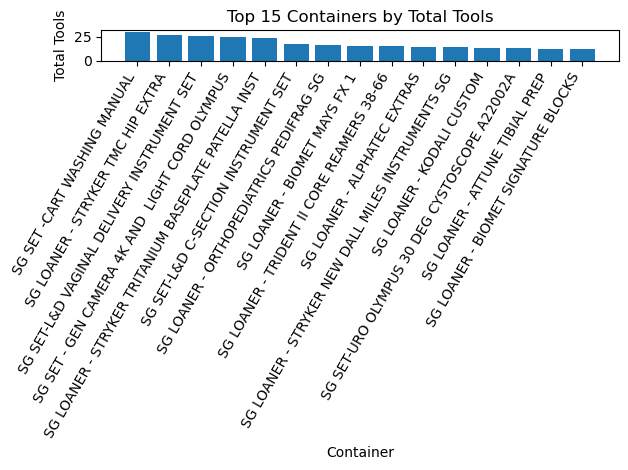

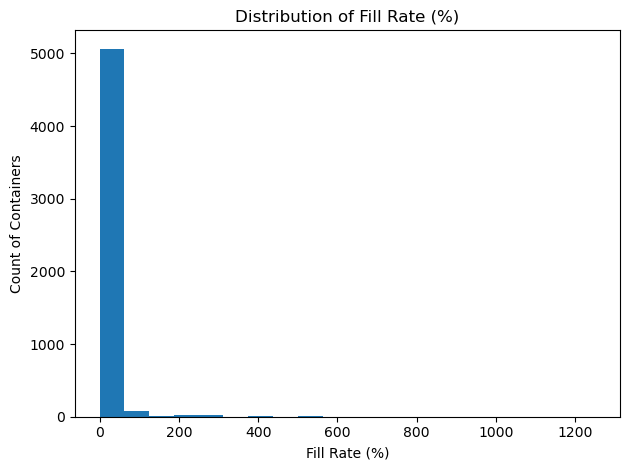

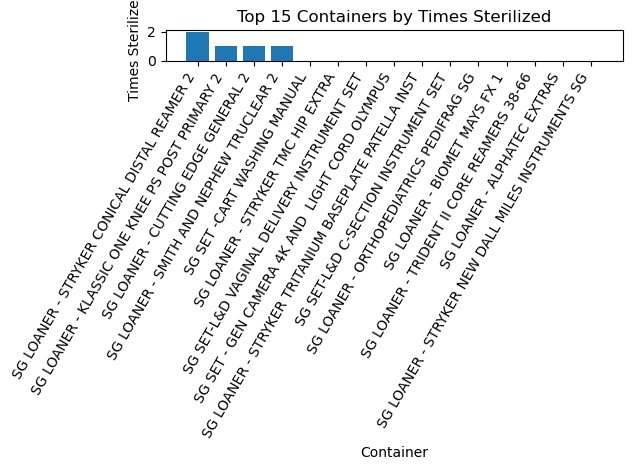

In [40]:
# Preview (Databricks/Notebook)
# display(summary.limit(20))  # uncomment if using Databricks

# -----------------------------
# 8) Flags: Low Fill & High Sterilization
# -----------------------------
# Use Spark approxQuantile for the 90th percentile threshold
q90 = summary.approxQuantile("Times Sterilized", [0.9], 0.0)[0] if summary.count() > 0 else None

flags = (summary
         .withColumn("Low Fill (<80%)", F.col("Fill Rate (%)") < 80)
         .withColumn("High Sterilization (Top 10%)",
                     F.when(F.lit(q90).isNotNull() & (F.col("Times Sterilized") >= F.lit(q90)), F.lit(True))
                      .otherwise(F.lit(False)))
        )

# -----------------------------
# 9) (Optional) Save outputs
# -----------------------------
# summary.coalesce(1).write.mode("overwrite").option("header", True).csv("/mnt/data/container_usage_summary_spark")
# flags.coalesce(1).write.mode("overwrite").option("header", True).csv("/mnt/data/container_flags_spark")

# -----------------------------
# 10) Visualizations (convert to Pandas for matplotlib)
# -----------------------------
import matplotlib.pyplot as plt

pdf = summary.toPandas()

# A) Top 15 by Total Tools
top_tools = pdf.nlargest(15, "Total Tools")
plt.figure()
plt.bar(top_tools["Container Name"], top_tools["Total Tools"])
plt.xticks(rotation=60, ha="right")
plt.title("Top 15 Containers by Total Tools")
plt.xlabel("Container")
plt.ylabel("Total Tools")
plt.tight_layout()
plt.show()

# B) Distribution of Fill Rate
plt.figure()
pdf["Fill Rate (%)"].dropna().plot(kind="hist", bins=20)
plt.title("Distribution of Fill Rate (%)")
plt.xlabel("Fill Rate (%)")
plt.ylabel("Count of Containers")
plt.tight_layout()
plt.show()

# C) Top 15 by Times Sterilized
top_ster = pdf.nlargest(15, "Times Sterilized")
plt.figure()
plt.bar(top_ster["Container Name"], top_ster["Times Sterilized"])
plt.xticks(rotation=60, ha="right")
plt.title("Top 15 Containers by Times Sterilized")
plt.xlabel("Container")
plt.ylabel("Times Sterilized")
plt.tight_layout()
plt.show()

# D) Missing Tools by Service (if present)
if "Service" in pdf.columns and pdf["Missing Tools"].sum() > 0:
    by_service = (pdf.groupby("Service", dropna=False)["Missing Tools"]
                    .sum()
                    .sort_values(ascending=False)
                    .head(10))
    plt.figure()
    by_service.plot(kind="bar")
    plt.title("Top Services by Missing Tools (Sum)")
    plt.xlabel("Service")
    plt.ylabel("Missing Tools")
    plt.tight_layout()
    plt.show()

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql import functions as F

try:
    pdf
except NameError:
    pdf = summary.toPandas()

StatementMeta(, feee0914-270a-42af-9555-54386589a685, 43, Finished, Available, Finished)

In [42]:
# ---------- Helper: annotate bars with values ----------
def annotate_bars(ax, orientation="v", fmt="{:.0f}"):
    if orientation == "v":  # vertical bars
        for p in ax.patches:
            height = p.get_height()
            if np.isfinite(height):
                ax.text(p.get_x() + p.get_width()/2, height, fmt.format(height),
                        ha="center", va="bottom", fontsize=8, rotation=0)
    else:  # horizontal bars
        for p in ax.patches:
            width = p.get_width()
            if np.isfinite(width):
                ax.text(width, p.get_y() + p.get_height()/2, fmt.format(width),
                        ha="left", va="center", fontsize=8, rotation=0)

StatementMeta(, feee0914-270a-42af-9555-54386589a685, 44, Finished, Available, Finished)

StatementMeta(, feee0914-270a-42af-9555-54386589a685, 45, Finished, Available, Finished)

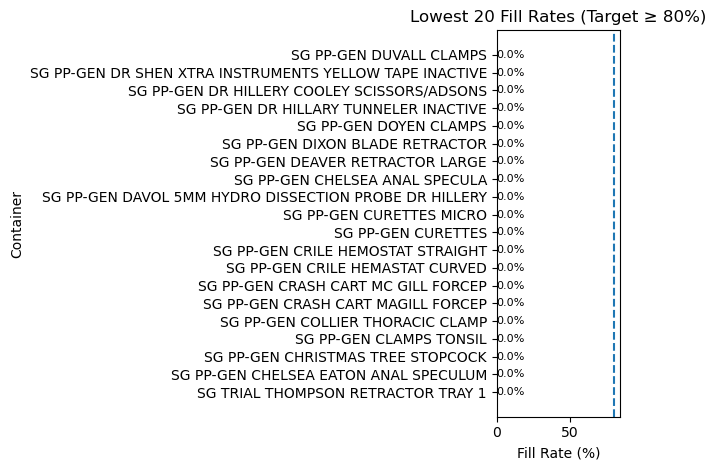

In [43]:
 # ============================================================
# 1) LOWEST FILL RATES (Bottom 20) — with target line at 80%
# ============================================================
if "Fill Rate (%)" in pdf.columns:
    low_fill = pdf.sort_values("Fill Rate (%)", ascending=True).head(20)
    plt.figure()
    ax = plt.gca()
    ax.barh(low_fill["Container Name"], low_fill["Fill Rate (%)"])
    ax.axvline(80, linestyle="--")  # target line (no specific color)
    annotate_bars(ax, orientation="h", fmt="{:.1f}%")
    plt.title("Lowest 20 Fill Rates (Target ≥ 80%)")
    plt.xlabel("Fill Rate (%)")
    plt.ylabel("Container")
    plt.tight_layout()
    plt.show()

StatementMeta(, feee0914-270a-42af-9555-54386589a685, 46, Finished, Available, Finished)

/tmp/ipykernel_6430/1112562922.py:14: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


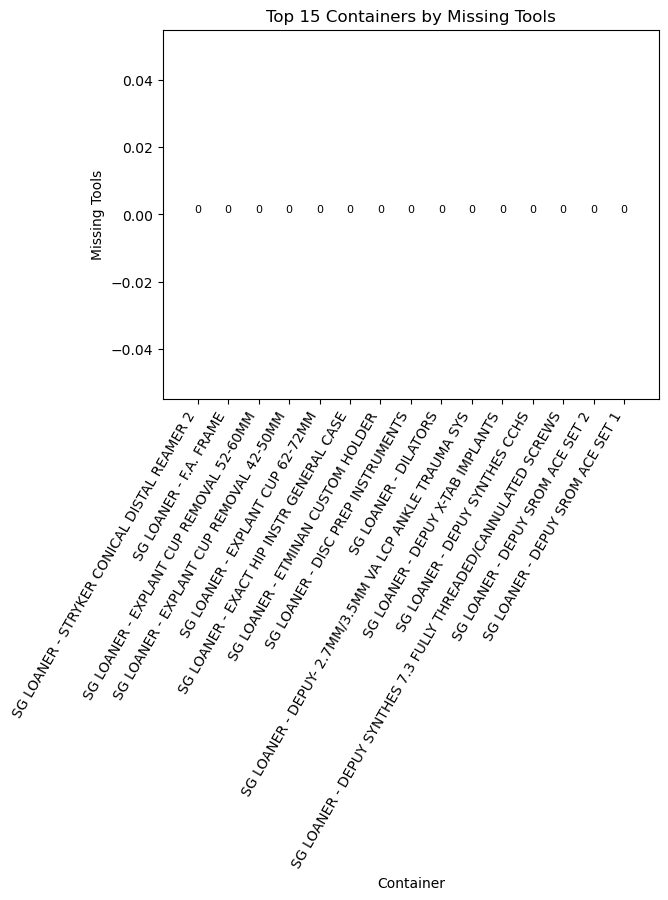

In [44]:
# ============================================================
# 2) MISSING TOOLS — Top 15 containers (bar with values)
# ============================================================
if "Missing Tools" in pdf.columns:
    top_missing = pdf.sort_values("Missing Tools", ascending=False).head(15)
    plt.figure()
    ax = plt.gca()
    ax.bar(top_missing["Container Name"], top_missing["Missing Tools"])
    plt.xticks(rotation=60, ha="right")
    annotate_bars(ax, orientation="v", fmt="{:.0f}")
    plt.title("Top 15 Containers by Missing Tools")
    plt.xlabel("Container")
    plt.ylabel("Missing Tools")
    plt.tight_layout()
    plt.show()

StatementMeta(, feee0914-270a-42af-9555-54386589a685, 47, Finished, Available, Finished)

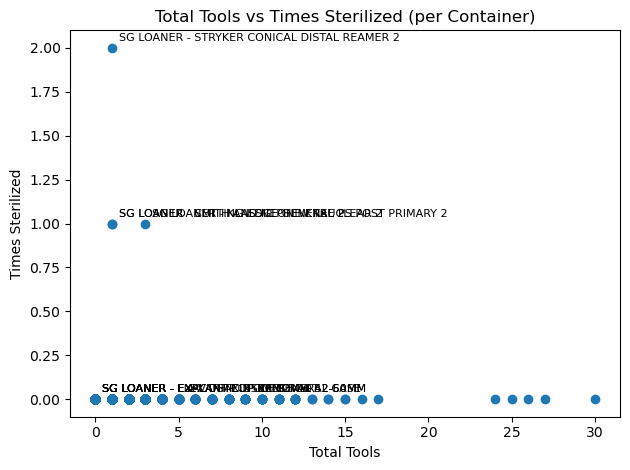

In [45]:
# ============================================================
# 3) TOOLS vs STERILIZATIONS — scatter + outlier labels
# ============================================================
if {"Total Tools", "Times Sterilized"}.issubset(pdf.columns):
    plt.figure()
    ax = plt.gca()
    ax.scatter(pdf["Total Tools"], pdf["Times Sterilized"])
    plt.title("Total Tools vs Times Sterilized (per Container)")
    plt.xlabel("Total Tools")
    plt.ylabel("Times Sterilized")
    # Annotate top 10 by sterilization
    topk = pdf.sort_values("Times Sterilized", ascending=False).head(10)
    for _, r in topk.iterrows():
        if np.isfinite(r["Total Tools"]) and np.isfinite(r["Times Sterilized"]):
            ax.annotate(str(r["Container Name"]),
                        (r["Total Tools"], r["Times Sterilized"]),
                        xytext=(5,5), textcoords="offset points", fontsize=8)
    plt.tight_layout()
    plt.show()


StatementMeta(, feee0914-270a-42af-9555-54386589a685, 48, Finished, Available, Finished)

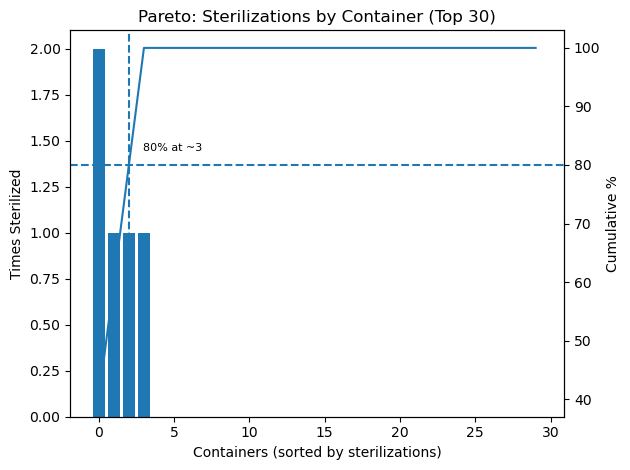

In [46]:
# ============================================================
# 4) PARETO of STERILIZATIONS — bars + cumulative % (1 figure)
# ============================================================
if "Times Sterilized" in pdf.columns:
    pareto = pdf[["Container Name", "Times Sterilized"]].dropna()
    pareto = pareto.sort_values("Times Sterilized", ascending=False)
    pareto["Cum%"] = pareto["Times Sterilized"].cumsum() / pareto["Times Sterilized"].sum() * 100

    top_n = 30  # plot top 30 for readability; tweak as needed
    x = np.arange(min(top_n, len(pareto)))
    plt.figure()
    ax1 = plt.gca()
    ax1.bar(x, pareto["Times Sterilized"].head(top_n))
    ax1.set_xlabel("Containers (sorted by sterilizations)")
    ax1.set_ylabel("Times Sterilized")
    ax1.set_title("Pareto: Sterilizations by Container (Top {})".format(top_n))

    ax2 = ax1.twinx()
    ax2.plot(x, pareto["Cum%"].head(top_n))
    ax2.set_ylabel("Cumulative %")

    # Mark 80% line + index where it crosses
    eighty_idx = np.argmax(pareto["Cum%"].values >= 80)
    ax2.axhline(80, linestyle="--")
    ax1.axvline(eighty_idx, linestyle="--")
    ax2.annotate("80% at ~{}".format(eighty_idx+1), (eighty_idx, 80),
                 xytext=(10,10), textcoords="offset points", fontsize=8)
    plt.tight_layout()
    plt.show()

In [47]:
# ============================================================
# 5) STERILIZATIONS OVER TIME — weekly counts + max annotation
# ============================================================
# Try to find any datetime column in df5 (Spark) for sterilization timestamp
dt_candidates = [c for c in df5.columns if any(k in c.lower() for k in ["date", "time", "timestamp"])]
if dt_candidates:
    ster_ts = F.coalesce(*[F.to_timestamp(F.col(c)) for c in dt_candidates])
    df5_time = df5.withColumn("SterTs", ster_ts).where(F.col("SterTs").isNotNull())
    weekly = (df5_time
              .groupBy(F.date_trunc("week", F.col("SterTs")).alias("Week"))
              .count()
              .orderBy("Week"))
    wpdf = weekly.toPandas()
    if not wpdf.empty:
        plt.figure()
        ax = plt.gca()
        ax.plot(wpdf["Week"], wpdf["count"], marker="o")
        plt.title("Weekly Sterilization Events")
        plt.xlabel("Week")
        plt.ylabel("Count")
        # Annotate the peak week
        imax = int(np.argmax(wpdf["count"].values))
        ax.annotate("Peak: {}".format(int(wpdf["count"].iloc[imax])),
                    (wpdf["Week"].iloc[imax], wpdf["count"].iloc[imax]),
                    xytext=(5,10), textcoords="offset points", fontsize=8)
        plt.tight_layout()
        plt.show()

StatementMeta(, feee0914-270a-42af-9555-54386589a685, 49, Finished, Available, Finished)

StatementMeta(, feee0914-270a-42af-9555-54386589a685, 50, Finished, Available, Finished)

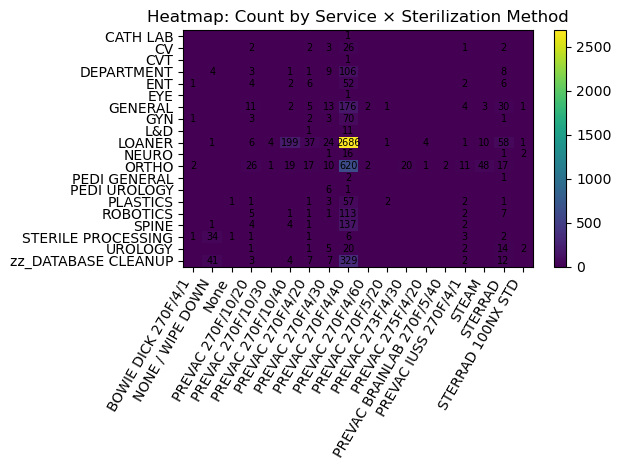

In [48]:
# ============================================================
# 6) HEATMAP — Service × Sterilization Method (counts)
# ============================================================
if ("Service" in df.columns) and ("Sterilization Method" in df.columns):
    svc_method = (df.groupBy("Service", "Sterilization Method")
                    .count()
                    .orderBy("Service", "Sterilization Method"))
    sm_pdf = svc_method.toPandas()
    if not sm_pdf.empty:
        pivot = sm_pdf.pivot(index="Service", columns="Sterilization Method", values="count").fillna(0)
        plt.figure()
        ax = plt.gca()
        im = ax.imshow(pivot.values, aspect="auto")  # default colormap; no explicit colors
        plt.colorbar(im)
        ax.set_xticks(range(pivot.shape[1]))
        ax.set_xticklabels(pivot.columns, rotation=60, ha="right")
        ax.set_yticks(range(pivot.shape[0]))
        ax.set_yticklabels(pivot.index)
        plt.title("Heatmap: Count by Service × Sterilization Method")
        # annotate cells
        for i in range(pivot.shape[0]):
            for j in range(pivot.shape[1]):
                val = int(pivot.values[i, j])
                if val > 0:
                    ax.text(j, i, str(val), ha="center", va="center", fontsize=7)
        plt.tight_layout()
        plt.show()

StatementMeta(, feee0914-270a-42af-9555-54386589a685, 51, Finished, Available, Finished)

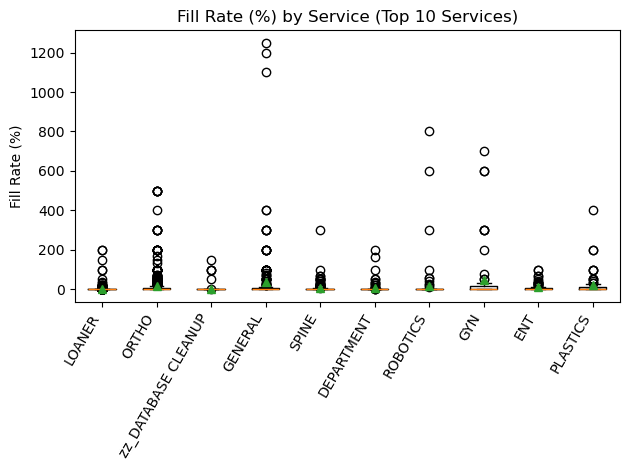

In [49]:
# ============================================================
# 7) BOX PLOT — Fill Rate by Service (top 10 services)
# ============================================================
if {"Service", "Fill Rate (%)"}.issubset(pdf.columns):
    # choose top 10 services by container count
    svc_counts = (pdf.groupby("Service")["Container Name"].count()
                    .sort_values(ascending=False).head(10).index.tolist())
    box_df = pdf[pdf["Service"].isin(svc_counts)].copy()
    groups = [box_df[box_df["Service"] == s]["Fill Rate (%)"].dropna().values for s in svc_counts]
    labels = svc_counts

    plt.figure()
    plt.boxplot(groups, labels=labels, showmeans=True)
    plt.xticks(rotation=60, ha="right")
    plt.title("Fill Rate (%) by Service (Top 10 Services)")
    plt.ylabel("Fill Rate (%)")
    plt.tight_layout()
    plt.show()

StatementMeta(, feee0914-270a-42af-9555-54386589a685, 52, Finished, Available, Finished)

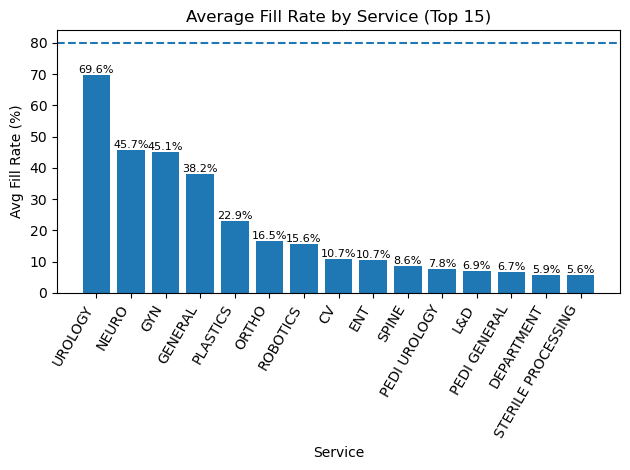

In [50]:
# ============================================================
# 8) SERVICE-LEVEL KPI BAR — Avg Fill Rate + annotations
# ============================================================
if {"Service", "Fill Rate (%)"}.issubset(pdf.columns):
    svc_fill = (pdf.groupby("Service", dropna=False)["Fill Rate (%)"]
                  .mean()
                  .sort_values(ascending=False)
                  .head(15))
    plt.figure()
    ax = plt.gca()
    ax.bar(svc_fill.index.astype(str), svc_fill.values)
    plt.xticks(rotation=60, ha="right")
    annotate_bars(ax, orientation="v", fmt="{:.1f}%")
    ax.axhline(80, linestyle="--")  # target line
    plt.title("Average Fill Rate by Service (Top 15)")
    plt.xlabel("Service")
    plt.ylabel("Avg Fill Rate (%)")
    plt.tight_layout()
    plt.show()

In [51]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import functions as F


StatementMeta(, feee0914-270a-42af-9555-54386589a685, 53, Finished, Available, Finished)

In [52]:
try:
    pdf
except NameError:
    pdf = summary.toPandas()

StatementMeta(, feee0914-270a-42af-9555-54386589a685, 54, Finished, Available, Finished)

In [53]:
REPORT_DIR = "figs_container_analysis"
os.makedirs(REPORT_DIR, exist_ok=True)

StatementMeta(, feee0914-270a-42af-9555-54386589a685, 55, Finished, Available, Finished)

In [54]:
# ---------- Plot settings ----------
plt.rcParams["figure.dpi"] = 140

StatementMeta(, feee0914-270a-42af-9555-54386589a685, 56, Finished, Available, Finished)

In [55]:
# ---------- Helpers ----------
def save_fig(title):
    fname = "".join(ch if ch.isalnum() or ch in "._- " else "_" for ch in title) + ".png"
    path = os.path.join(REPORT_DIR, fname)
    plt.savefig(path, bbox_inches="tight")
    print("Saved:", path)

StatementMeta(, feee0914-270a-42af-9555-54386589a685, 57, Finished, Available, Finished)

In [56]:
def annotate_bars(ax, orientation="v", fmt="{:.0f}", fontsize=8):
    if orientation == "v":
        for p in ax.patches:
            h = p.get_height()
            if np.isfinite(h):
                ax.text(p.get_x()+p.get_width()/2, h, fmt.format(h),
                        ha="center", va="bottom", fontsize=fontsize)
    else:
        for p in ax.patches:
            w = p.get_width()
            if np.isfinite(w):
                ax.text(w, p.get_y()+p.get_height()/2, fmt.format(w),
                        ha="left", va="center", fontsize=fontsize)


StatementMeta(, feee0914-270a-42af-9555-54386589a685, 58, Finished, Available, Finished)

StatementMeta(, feee0914-270a-42af-9555-54386589a685, 59, Finished, Available, Finished)

Saved: figs_container_analysis/fill_rate_hist_50bins.png


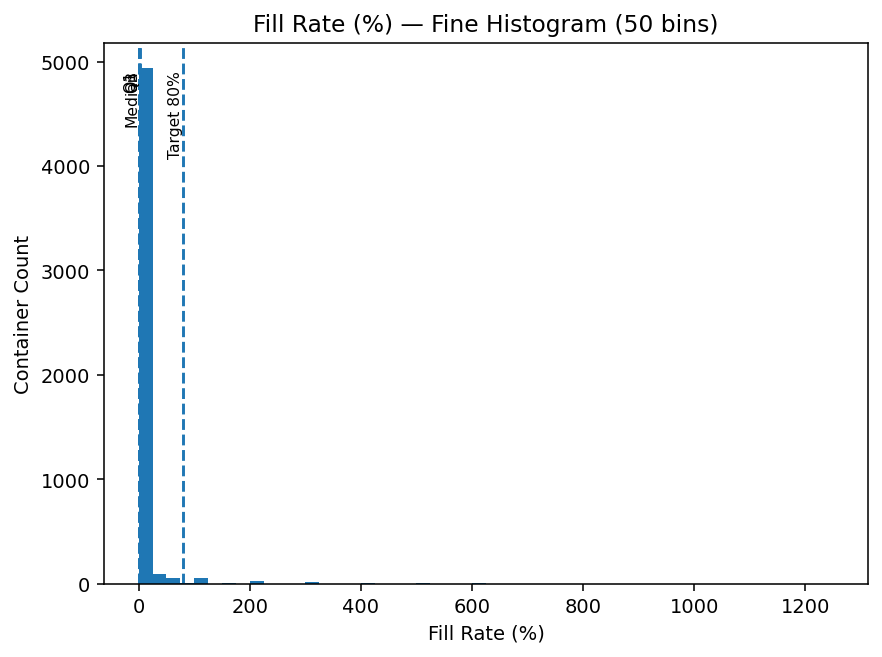

In [57]:
if "Fill Rate (%)" in pdf.columns:
    # High-resolution histogram with quantile lines
    vals = pdf["Fill Rate (%)"].dropna().values
    if len(vals) > 0:
        q25, q50, q75 = np.percentile(vals, [25, 50, 75])
        plt.figure()
        plt.hist(vals, bins=50)
        ax = plt.gca()
        for q, lbl in [(q25, "Q1"), (q50, "Median"), (q75, "Q3")]:
            ax.axvline(q, linestyle="--")
            ax.text(q, ax.get_ylim()[1]*0.95, lbl, rotation=90, va="top", ha="right", fontsize=8)
        ax.axvline(80, linestyle="--")
        ax.text(80, ax.get_ylim()[1]*0.95, "Target 80%", rotation=90, va="top", ha="right", fontsize=8)
        plt.title("Fill Rate (%) — Fine Histogram (50 bins)")
        plt.xlabel("Fill Rate (%)")
        plt.ylabel("Container Count")
        plt.tight_layout()
        save_fig("fill_rate_hist_50bins")
        plt.show()


StatementMeta(, feee0914-270a-42af-9555-54386589a685, 60, Finished, Available, Finished)

Saved: figs_container_analysis/fill_rate_ecdf.png


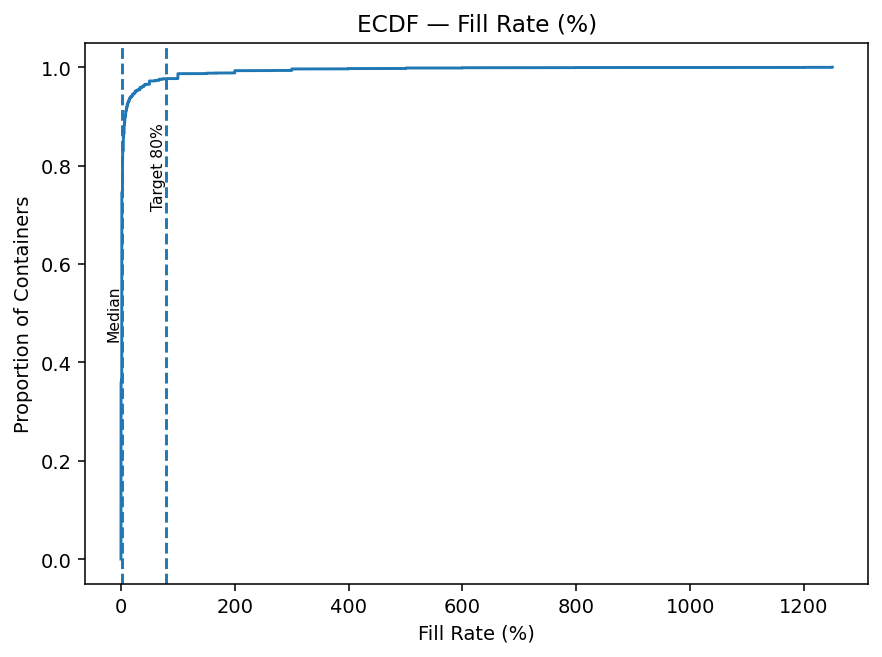

In [58]:
# ECDF
x = np.sort(vals)
y = np.arange(1, len(x)+1) / len(x)
plt.figure()
plt.plot(x, y, drawstyle="steps-post")
plt.title("ECDF — Fill Rate (%)")
plt.xlabel("Fill Rate (%)")
plt.ylabel("Proportion of Containers")
# annotate med/target
plt.axvline(q50, linestyle="--"); plt.text(q50, 0.5, "Median", rotation=90, va="center", ha="right", fontsize=8)
plt.axvline(80, linestyle="--");  plt.text(80, 0.8, "Target 80%", rotation=90, va="center", ha="right", fontsize=8)
plt.tight_layout()
save_fig("fill_rate_ecdf")
plt.show()

StatementMeta(, feee0914-270a-42af-9555-54386589a685, 61, Finished, Available, Finished)

Saved: figs_container_analysis/times_sterilized_hist_50bins.png


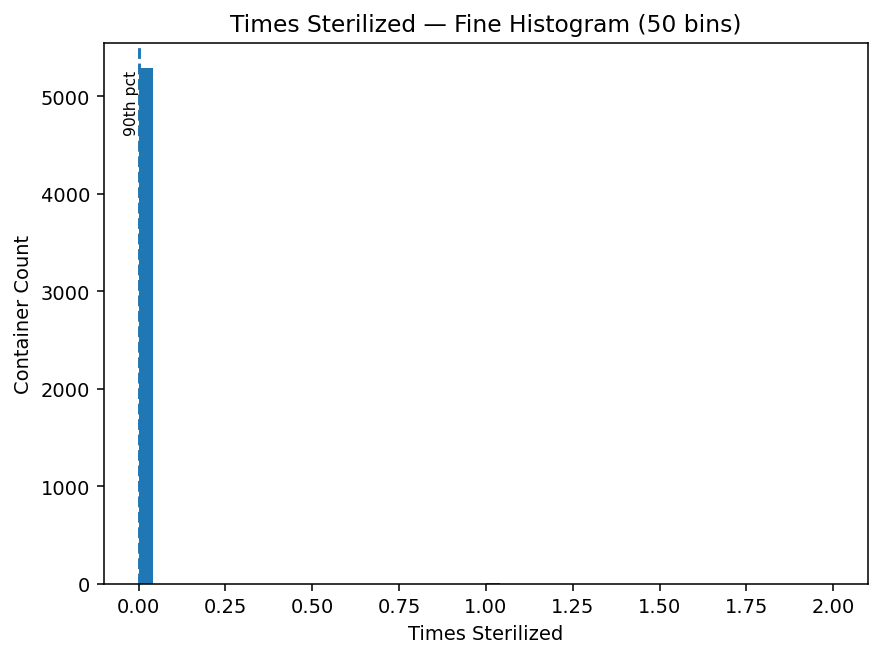

In [59]:
if "Times Sterilized" in pdf.columns:
    vals = pdf["Times Sterilized"].dropna().values
    if len(vals) > 0:
        plt.figure()
        plt.hist(vals, bins=50)
        ax = plt.gca()
        p90 = np.percentile(vals, 90)
        ax.axvline(p90, linestyle="--")
        ax.text(p90, ax.get_ylim()[1]*0.95, "90th pct", rotation=90, va="top", ha="right", fontsize=8)
        plt.title("Times Sterilized — Fine Histogram (50 bins)")
        plt.xlabel("Times Sterilized")
        plt.ylabel("Container Count")
        plt.tight_layout()
        save_fig("times_sterilized_hist_50bins")
        plt.show()

StatementMeta(, feee0914-270a-42af-9555-54386589a685, 62, Finished, Available, Finished)

Saved: figs_container_analysis/times_sterilized_ecdf.png


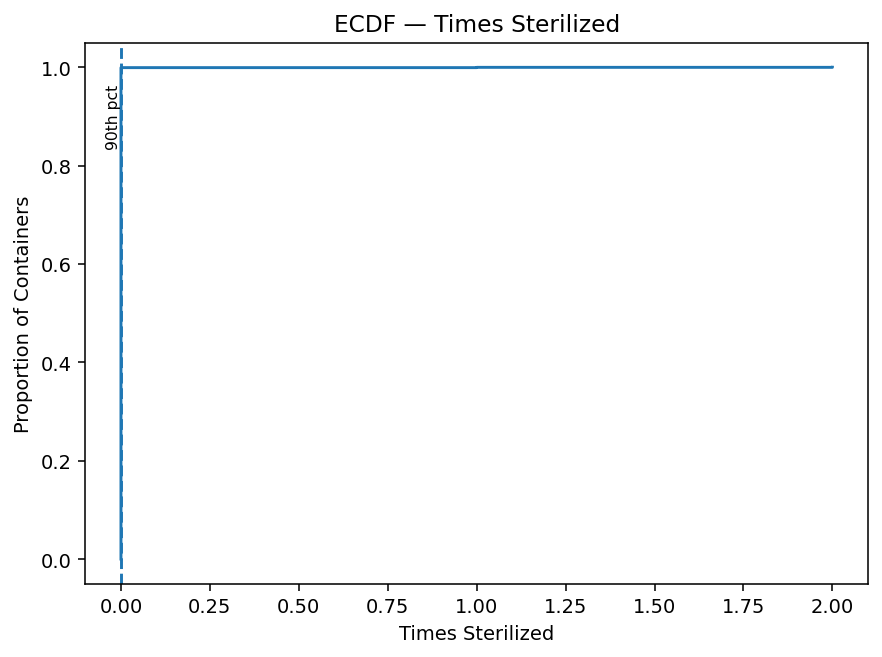

In [60]:
x = np.sort(vals)
y = np.arange(1, len(x)+1) / len(x)
plt.figure()
plt.plot(x, y, drawstyle="steps-post")
plt.title("ECDF — Times Sterilized")
plt.xlabel("Times Sterilized")
plt.ylabel("Proportion of Containers")
plt.axvline(p90, linestyle="--"); plt.text(p90, 0.9, "90th pct", rotation=90, va="center", ha="right", fontsize=8)
plt.tight_layout()
save_fig("times_sterilized_ecdf")
plt.show()

StatementMeta(, feee0914-270a-42af-9555-54386589a685, 63, Finished, Available, Finished)

Saved: figs_container_analysis/hexbin_tools_vs_sterilizations.png


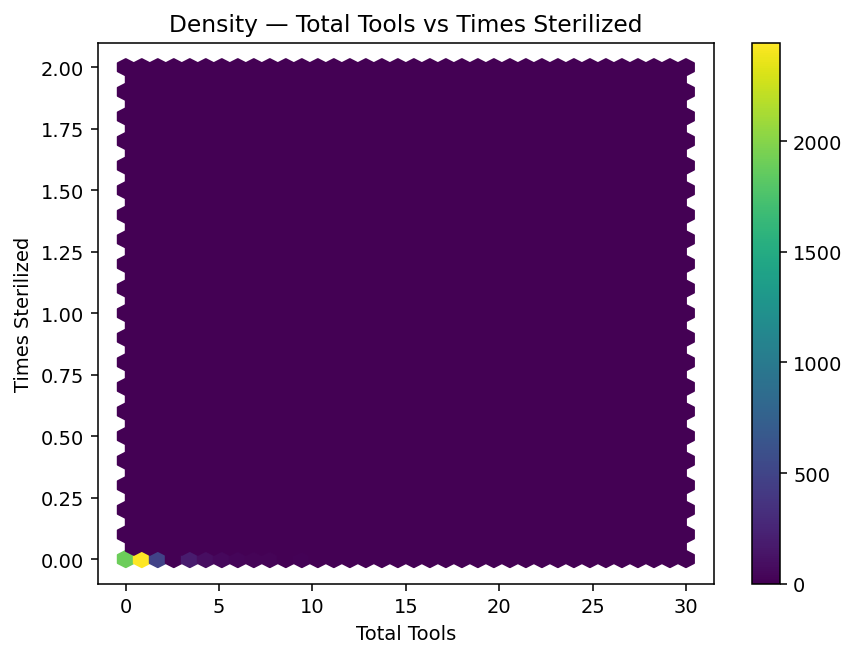

In [61]:
# 2) DENSITY (HEXBIN) SCATTERS + TRENDLINES
# ============================================================
if {"Total Tools", "Times Sterilized"}.issubset(pdf.columns):
    sub = pdf[["Total Tools", "Times Sterilized", "Container Name"]].dropna()
    if len(sub) > 0:
        # Hexbin density
        plt.figure()
        hb = plt.hexbin(sub["Total Tools"].values, sub["Times Sterilized"].values, gridsize=35)
        plt.title("Density — Total Tools vs Times Sterilized")
        plt.xlabel("Total Tools")
        plt.ylabel("Times Sterilized")
        plt.colorbar(hb)
        plt.tight_layout()
        save_fig("hexbin_tools_vs_sterilizations")
        plt.show()

StatementMeta(, feee0914-270a-42af-9555-54386589a685, 64, Finished, Available, Finished)

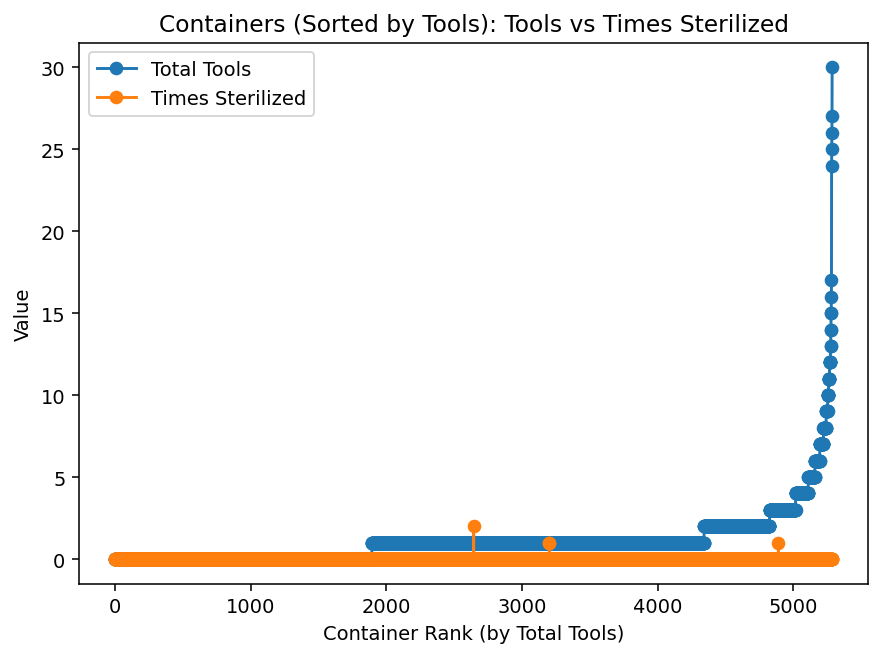

In [62]:
# Two lines over container rank (sorted by Total Tools)
sub_ranked = sub[["Total Tools", "Times Sterilized", "Container Name"]].dropna().sort_values("Total Tools")
idx = np.arange(len(sub_ranked))

plt.figure()
plt.plot(idx, sub_ranked["Total Tools"].values, marker="o", label="Total Tools")
plt.plot(idx, sub_ranked["Times Sterilized"].values, marker="o", label="Times Sterilized")
plt.title("Containers (Sorted by Tools): Tools vs Times Sterilized")
plt.xlabel("Container Rank (by Total Tools)")
plt.ylabel("Value")
plt.legend()
plt.tight_layout()
plt.show()

StatementMeta(, feee0914-270a-42af-9555-54386589a685, 65, Finished, Available, Finished)

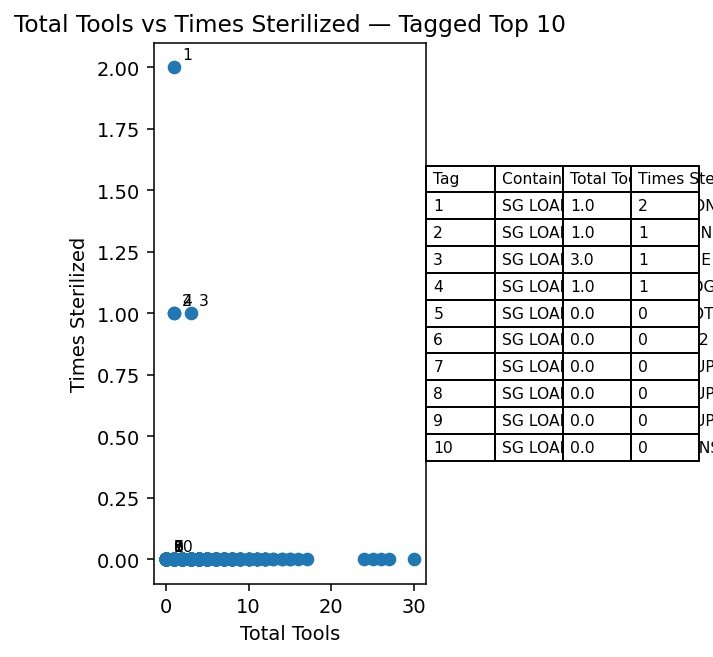

In [63]:
# --- CLEAN TAGGED VIEW (replace your messy annotate block) ---
sub_sorted = sub[["Total Tools","Times Sterilized","Container Name"]].dropna()
top10 = sub_sorted.sort_values("Times Sterilized", ascending=False).head(10).copy()
top10["Tag"] = np.arange(1, len(top10)+1)

plt.figure()
ax = plt.gca()

# use line or scatter — your choice:
# ax.plot(sub_sorted["Total Tools"], sub_sorted["Times Sterilized"], marker="o")      # line
ax.plot(sub_sorted["Total Tools"], sub_sorted["Times Sterilized"], marker="o", linestyle="")  # scatter

# tiny numeric tags near top-10 points
for _, r in top10.iterrows():
    ax.annotate(str(int(r["Tag"])),
                (r["Total Tools"], r["Times Sterilized"]),
                xytext=(4, 4), textcoords="offset points", fontsize=8)

plt.title("Total Tools vs Times Sterilized — Tagged Top 10")
plt.xlabel("Total Tools")
plt.ylabel("Times Sterilized")

# add side table mapping Tag → Container (plus values)
mapping = top10[["Tag","Container Name","Total Tools","Times Sterilized"]]
tbl = plt.table(cellText=mapping.values,
                colLabels=mapping.columns,
                loc="right", colLoc="left", cellLoc="left")
tbl.auto_set_font_size(False)
tbl.set_fontsize(8)
tbl.scale(1, 1.1)

plt.subplots_adjust(right=0.68)  # make room for the table
plt.tight_layout()
# save_fig("tools_vs_sterilized_tagged")  # optional if you use save_fig()
plt.show()

In [64]:
dt_candidates = [c for c in df5.columns if any(k in c.lower() for k in ["date", "time", "timestamp"])]
if dt_candidates:
    ster_ts = F.coalesce(*[F.to_timestamp(F.col(c)) for c in dt_candidates])
    df5_time = df5.withColumn("SterTs", ster_ts).where(F.col("SterTs").isNotNull())
    weekly = (df5_time
              .groupBy(F.date_trunc("week", F.col("SterTs")).alias("Week"))
              .count()
              .orderBy("Week"))
    wpdf = weekly.toPandas()
    if not wpdf.empty:
        y = wpdf["count"].astype(float).values
        mu, sigma = np.mean(y), np.std(y, ddof=1) if len(y) > 1 else (np.mean(y), 0.0)
        plt.figure()
        plt.plot(wpdf["Week"], y, marker="o")
        plt.axhline(mu, linestyle="--"); plt.text(wpdf["Week"].iloc[0], mu, "Mean", va="bottom", fontsize=8)
        if sigma > 0:
            plt.axhline(mu + 3*sigma, linestyle="--")
            plt.axhline(mu - 3*sigma, linestyle="--")
            plt.text(wpdf["Week"].iloc[0], mu + 3*sigma, "+3σ", va="bottom", fontsize=8)
            plt.text(wpdf["Week"].iloc[0], mu - 3*sigma, "-3σ", va="bottom", fontsize=8)
        plt.title("Weekly Sterilization Events — Control Chart")
        plt.xlabel("Week")
        plt.ylabel("Count")
        # peak annotation
        imax = int(np.argmax(y))
        plt.annotate("Peak: {}".format(int(y[imax])),
                     (wpdf["Week"].iloc[imax], y[imax]),
                     xytext=(5,10), textcoords="offset points", fontsize=8)
        plt.tight_layout()
        save_fig("weekly_sterilizations_control_chart")
        plt.show()

StatementMeta(, feee0914-270a-42af-9555-54386589a685, 66, Finished, Available, Finished)

StatementMeta(, feee0914-270a-42af-9555-54386589a685, 67, Finished, Available, Finished)

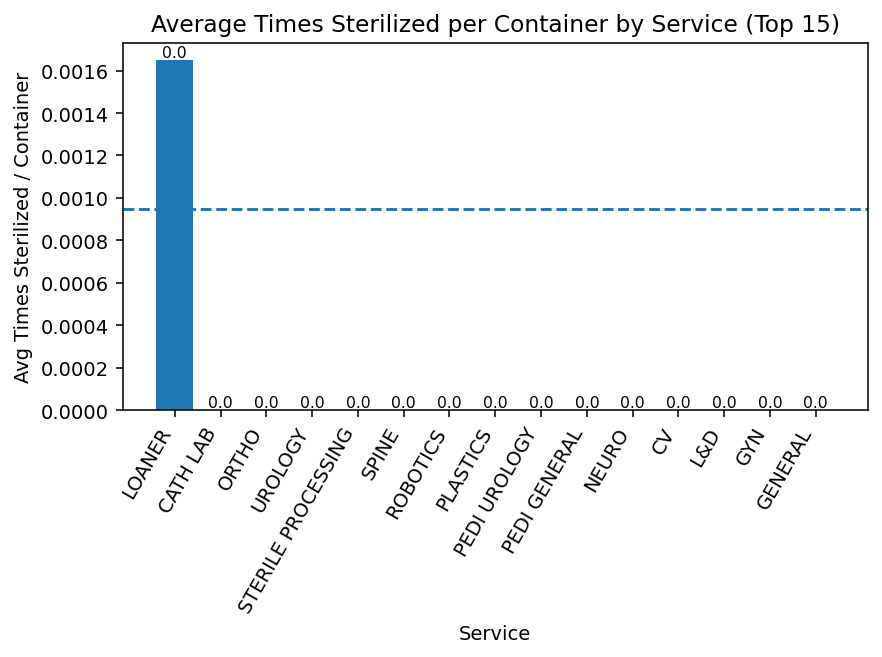

In [65]:
if {"Service", "Times Sterilized"}.issubset(pdf.columns):
    svc_ts = (pdf.groupby("Service", dropna=False)["Times Sterilized"]
                .mean()
                .sort_values(ascending=False)
                .head(15))
    plt.figure()
    ax = plt.gca()
    ax.bar(svc_ts.index.astype(str), svc_ts.values)
    plt.xticks(rotation=60, ha="right")
    annotate_bars(ax, orientation="v", fmt="{:.1f}")
    ax.axhline(pdf["Times Sterilized"].mean(), linestyle="--")  # overall mean guide
    plt.title("Average Times Sterilized per Container by Service (Top 15)")
    plt.xlabel("Service")
    plt.ylabel("Avg Times Sterilized / Container")
    plt.tight_layout()
    plt.show()

StatementMeta(, feee0914-270a-42af-9555-54386589a685, 68, Finished, Available, Finished)

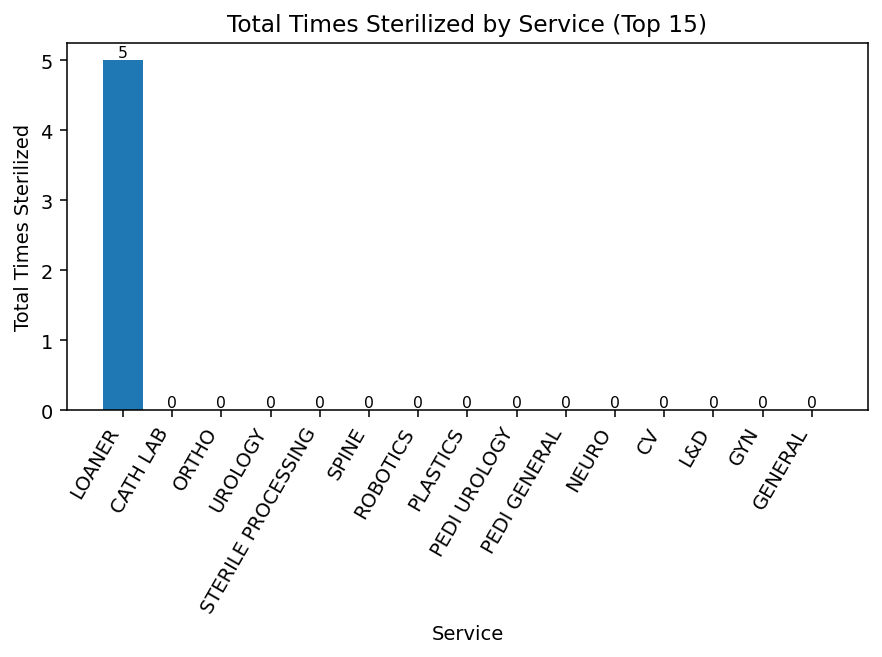

In [66]:
# Optional: Total Times Sterilized by Service (Top 15)
svc_ts_total = (pdf.groupby("Service", dropna=False)["Times Sterilized"]
                  .sum()
                  .sort_values(ascending=False)
                  .head(15))
plt.figure()
ax = plt.gca()
ax.bar(svc_ts_total.index.astype(str), svc_ts_total.values)
plt.xticks(rotation=60, ha="right")
annotate_bars(ax, orientation="v", fmt="{:.0f}")
plt.title("Total Times Sterilized by Service (Top 15)")
plt.xlabel("Service")
plt.ylabel("Total Times Sterilized")
plt.tight_layout()
plt.show()


In [67]:
daily = (df5_time
         .groupBy(F.to_date("Sterilized Date/Time").alias("Day"))
         .count()
         .orderBy("Day"))
dpdf = daily.toPandas().sort_values("Day")
if not dpdf.empty:
    s = dpdf.set_index("Day")["count"].asfreq("D").fillna(0)
    s_roll7 = s.rolling(7, min_periods=1, center=False).mean()

    plt.figure()
    plt.plot(s.index, s.values, marker=".")
    plt.plot(s_roll7.index, s_roll7.values, linestyle="--")
    plt.title("Daily Sterilization Events (with 7-Day Rolling Avg)")
    plt.xlabel("Day")
    plt.ylabel("Count")
    # annotate peak
    imax = int(np.argmax(s.values))
    plt.annotate(f"Peak: {int(s.values[imax])}",
                 (s.index[imax], s.values[imax]),
                 xytext=(5,10), textcoords="offset points", fontsize=8)
    plt.tight_layout()
    # save_fig("daily_sterilizations_with_7day_avg")
    plt.show()

StatementMeta(, feee0914-270a-42af-9555-54386589a685, 69, Finished, Available, Finished)

##### Finding the Keys between the datasets and identifying the relations

In [68]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window
import re

StatementMeta(, feee0914-270a-42af-9555-54386589a685, 70, Finished, Available, Finished)

In [69]:
# ---------- helpers ----------
def pick(cols, *cands):
    for c in cands:
        if c and c in cols: return c
    return None

def norm_key(col):
    return F.upper(F.regexp_replace(F.regexp_replace(F.trim(col), r"\s+", " "), r"[^A-Za-z0-9]", ""))


StatementMeta(, feee0914-270a-42af-9555-54386589a685, 71, Finished, Available, Finished)

In [70]:
def norm_text(s: str) -> str:
    return re.sub(r"[^a-z0-9]", "", s.lower())

def smart_pick(cols, exact=None, aliases=None, contains=None, exclude_contains=None):
    """
    Choose a column from `cols` robustly:
    1) exact match (case sensitive, then case-insensitive)
    2) aliases list (any)
    3) fuzzy: first column whose normalized name contains ALL tokens in `contains`
       and does NOT contain any token in `exclude_contains`.
    Returns the column name or raises a ValueError with a helpful message.
    """
    if aliases is None: aliases = []
    if contains is None: contains = []
    if exclude_contains is None: exclude_contains = []

    # 1) exact (case-sensitive)
    if exact and exact in cols:
        return exact
    # 1b) exact (case-insensitive)
    if exact:
        for c in cols:
            if c.lower() == exact.lower():
                return c

    # 2) aliases
    for a in aliases:
        if a in cols:
            return a
    for a in aliases:
        for c in cols:
            if c.lower() == a.lower():
                return c

    # 3) fuzzy contains
    ncols = [(c, norm_text(c)) for c in cols]
    need = [norm_text(t) for t in contains]
    ban  = [norm_text(t) for t in exclude_contains]
    for orig, norm in ncols:
        if all(t in norm for t in need) and all(b not in norm for b in ban):
            return orig

    raise ValueError(
        f"Could not find a suitable column. Tried exact={exact}, aliases={aliases}, contains={contains}. "
        f"Available columns: {cols}"
    )

def norm_key(col):
    return F.upper(
        F.regexp_replace(
            F.regexp_replace(F.trim(col), r"\s+", " "),
            r"[^A-Za-z0-9]",
            ""
        )
    )

StatementMeta(, feee0914-270a-42af-9555-54386589a685, 72, Finished, Available, Finished)

In [71]:
# =============== 1) Inventory bridge (source of truth) ===============
inv_name  = pick(df2.columns, "Container Name", "Container")
inv_act   = pick(df2.columns, "Container Actual", "Actual Container")
inv_bar   = pick(df2.columns, "Container Barcode", "Barcode", "Serial", "Container Serial Number")

inv_bridge = (df2
    .withColumn("NameKey",   norm_key(F.col(inv_name)))     # logical (GenKey)
    .withColumn("ActualKey", norm_key(F.col(inv_act)))      # physical text id
    .withColumn("SerialKey", norm_key(F.col(inv_bar)))      # barcode / serial
    .dropna(subset=["NameKey"])                             # must have name
    .dropDuplicates(["NameKey","ActualKey","SerialKey"])
    .cache()
)

StatementMeta(, feee0914-270a-42af-9555-54386589a685, 73, Finished, Available, Finished)

In [72]:
# =============== 2) Key each non-inventory dataset ===============
# GI — Container Name -> NameKey
gi_name = pick(df.columns, "Container Name")
gi_keyed = df.withColumn("NameKey", norm_key(F.col(gi_name)))

StatementMeta(, feee0914-270a-42af-9555-54386589a685, 74, Finished, Available, Finished)

In [73]:
# PD — Container -> NameKey
pd_cont = pick(df3.columns, "Container Name")
pd_keyed = df3.withColumn("NameKey", norm_key(F.col(pd_cont)))

StatementMeta(, feee0914-270a-42af-9555-54386589a685, 75, Finished, Available, Finished)

In [74]:
# ST — Container -> ActualKey, then resolve SerialKey from bridge
st_cont = pick(df5.columns, "Container Name")
st_keyed = (df5
    .withColumn("ActualKey", norm_key(F.col(st_cont)))
    .join(inv_bridge.select("ActualKey","SerialKey","NameKey").dropDuplicates(["ActualKey"]),
          on="ActualKey", how="left")
)

StatementMeta(, feee0914-270a-42af-9555-54386589a685, 76, Finished, Available, Finished)

In [75]:
# MI — Container -> ActualKey, then resolve SerialKey from bridge
mi_cont = pick(df4.columns, "Container Name")
mi_keyed = (df4
    .withColumn("ActualKey", norm_key(F.col(mi_cont)))
    .join(inv_bridge.select("ActualKey","SerialKey","NameKey").dropDuplicates(["ActualKey"]),
          on="ActualKey", how="left")
)

StatementMeta(, feee0914-270a-42af-9555-54386589a685, 77, Finished, Available, Finished)

In [76]:
from pyspark.sql import functions as F

def pick_ci(cols, *opts):
    low = {c.lower(): c for c in cols}
    for o in opts:
        if o and o.lower() in low:
            return low[o.lower()]
    return None

StatementMeta(, feee0914-270a-42af-9555-54386589a685, 78, Finished, Available, Finished)

In [77]:
# =============== 3) Merges (SerialKey is the disambiguator) =============== 
# Start from bridge rows that actually have a SerialKey 
base = inv_bridge.filter(F.col("SerialKey").isNotNull()).alias("inv") 
# A) + General Info by NameKey (brings GI attributes into the serial-backed row) 
m1 = base.join(gi_keyed.alias("gi"), on=F.col("inv.NameKey")==F.col("gi.NameKey"), how="left") 
# B) + Product Detail by NameKey 
m2 = m1.join(pd_keyed.alias("pd"), on=F.col("inv.NameKey")==F.col("pd.NameKey"), how="left")
# C) + Sterilization by SerialKey (events resolved to barcode) 
st_dedup = st_keyed.dropna(subset=["SerialKey"]).dropDuplicates(["SerialKey"])
m3 = m2.join(st_dedup.alias("st"), on=F.col("inv.SerialKey")==F.col("st.SerialKey"), how="left") 
# D) + Missing Instruments by SerialKey 
mi_dedup = mi_keyed.dropna(subset=["SerialKey"]).dropDuplicates(["SerialKey"]) 
final_merged = m3.join(mi_dedup.alias("mi"), on=F.col("inv.SerialKey")==F.col("mi.SerialKey"), how="left") 
# =============== 4) (Optional) Latest sterilization per SerialKey =============== 
# If you want only the latest ST record attached: 
st_ts = pick(st_keyed.columns, "Sterilized Date/Time", "Start Time", "Timestamp") 
if st_ts:
    from pyspark.sql import Window 
    w = Window.partitionBy("SerialKey").orderBy(F.col(st_ts).cast("timestamp").desc()) 
    st_latest = (st_keyed .withColumn("rn", F.row_number().over(w)) .filter("rn=1").drop("rn")) 
    final_merged = (m2 .join(st_latest.dropna(subset=["SerialKey"]).dropDuplicates(["SerialKey"]).alias("st"), on=F.col("inv.SerialKey")==F.col("st.SerialKey"), how="left") .join(mi_dedup.alias("mi"), on=F.col("inv.SerialKey")==F.col("mi.SerialKey"), how="left"))

StatementMeta(, feee0914-270a-42af-9555-54386589a685, 79, Finished, Available, Finished)

In [78]:
# ----- 4.1 Minimal, aliased projections (no duplicates) -----

# Base (from inventory bridge) — pick only the keys and any base attrs you want to expose
base_sel = inv_bridge.select(
    F.col("SerialKey"),
    F.col("NameKey"),
    F.col("ActualKey"),
    F.col(pick_ci(inv_bridge.columns, "Service") or "NameKey").alias("Service")  # fallback if Service not present
)

StatementMeta(, feee0914-270a-42af-9555-54386589a685, 80, Finished, Available, Finished)

In [79]:
# GI (by NameKey)
gi_cn = pick_ci(df.columns, "Container Name", "Container")
gi_sm = pick_ci(df.columns, "Sterilization Method")
gi_sel = gi_keyed.select(
    "NameKey",
    *( [F.col(gi_cn).alias("GI_ContainerName")] if gi_cn else [] ),
    *( [F.col(gi_sm).alias("GI_SterilizationMethod")] if gi_sm else [] )
)

StatementMeta(, feee0914-270a-42af-9555-54386589a685, 81, Finished, Available, Finished)

In [80]:
from pyspark.sql import functions as F

def q(colname: str):
    # quote any column that has spaces, dots, or special chars
    return F.col(f"`{colname}`")

StatementMeta(, feee0914-270a-42af-9555-54386589a685, 82, Finished, Available, Finished)

In [81]:
# ---- PD slim view with aliases (safer + unambiguous) ----
# pick the headers you actually have
pd_cn  = "Container Name"  if "Container Name"  in df3.columns else "Container"
pd_qty = "Total Ext. Qty"  # you DO have this (per the error message)

pd_sel = (pd_keyed
    .select(
        "NameKey",
        *( [q(pd_cn).alias("PD_ContainerName")] if pd_cn in df3.columns else [] ),
        q(pd_qty).cast("double").alias("PD_TotalQty")
    )
)

StatementMeta(, feee0914-270a-42af-9555-54386589a685, 83, Finished, Available, Finished)

In [82]:
# ST (by SerialKey) – resolved via bridge earlier
st_ts  = pick_ci(st_keyed.columns, "Sterilized Date/Time", "Start Time", "Timestamp")
st_res = pick_ci(st_keyed.columns, "Load Result", "Result", "Outcome")
st_sel = st_keyed.select(
    "SerialKey",
    *( [F.col(st_ts).alias("ST_SterilizedTs")] if st_ts else [] ),
    *( [F.col(st_res).alias("ST_LoadResult")] if st_res else [] )
).dropDuplicates(["SerialKey"])

StatementMeta(, feee0914-270a-42af-9555-54386589a685, 84, Finished, Available, Finished)

In [83]:
# MI (by SerialKey)
mi_item = pick_ci(mi_keyed.columns, "Catalog Name", "Item Name", "Instrument Name")
mi_qty  = pick_ci(mi_keyed.columns, "Qty Missing", "Quantity Missing", "Missing Qty")
mi_sel = mi_keyed.select(
    "SerialKey",
    *( [F.col(mi_item).alias("MI_Item")] if mi_item else [] ),
    *( [F.col(mi_qty).cast("double").alias("MI_QtyMissing")] if mi_qty else [] )
).dropDuplicates(["SerialKey"])

StatementMeta(, feee0914-270a-42af-9555-54386589a685, 85, Finished, Available, Finished)

In [84]:
# ----- 4.2 Join the aliased views (no ambiguity now) -----
j1 = base_sel.alias("inv").join(gi_sel, on="NameKey", how="left")
j2 = j1.join(pd_sel, on="NameKey", how="left")
j3 = j2.join(st_sel, on="SerialKey", how="left")
final_merged_clean = j3.join(mi_sel, on="SerialKey", how="left")

StatementMeta(, feee0914-270a-42af-9555-54386589a685, 86, Finished, Available, Finished)

In [85]:
# ----- 5) Curated projection (simple and unambiguous) -----
curated = final_merged_clean.select(
    "SerialKey",
    F.col("NameKey").alias("GenKey"),
    "ActualKey",
    "Service",
    # GI & PD
    *( ["GI_ContainerName"] if "GI_ContainerName" in final_merged_clean.columns else [] ),
    *( ["GI_SterilizationMethod"] if "GI_SterilizationMethod" in final_merged_clean.columns else [] ),
    *( ["PD_ContainerName"] if "PD_ContainerName" in final_merged_clean.columns else [] ),
    *( ["PD_TotalQty"] if "PD_TotalQty" in final_merged_clean.columns else [] ),
    # ST
    *( ["ST_SterilizedTs"] if "ST_SterilizedTs" in final_merged_clean.columns else [] ),
    *( ["ST_LoadResult"] if "ST_LoadResult" in final_merged_clean.columns else [] ),
    # MI
    *( ["MI_Item"] if "MI_Item" in final_merged_clean.columns else [] ),
    *( ["MI_QtyMissing"] if "MI_QtyMissing" in final_merged_clean.columns else [] ),
)


StatementMeta(, feee0914-270a-42af-9555-54386589a685, 87, Finished, Available, Finished)

In [86]:
# Quick sanity checks
print("Bridge rows with SerialKey:", inv_bridge.filter(F.col("SerialKey").isNotNull()).count())
print("ST rows resolved to SerialKey:", st_keyed.filter(F.col("SerialKey").isNotNull()).count())
print("MI rows resolved to SerialKey:", mi_keyed.filter(F.col("SerialKey").isNotNull()).count())

StatementMeta(, feee0914-270a-42af-9555-54386589a685, 88, Finished, Available, Finished)

Bridge rows with SerialKey: 9996
ST rows resolved to SerialKey: 60742
MI rows resolved to SerialKey: 447


ANALYTICS AFTER KEYS 

StatementMeta(, feee0914-270a-42af-9555-54386589a685, 89, Finished, Available, Finished)

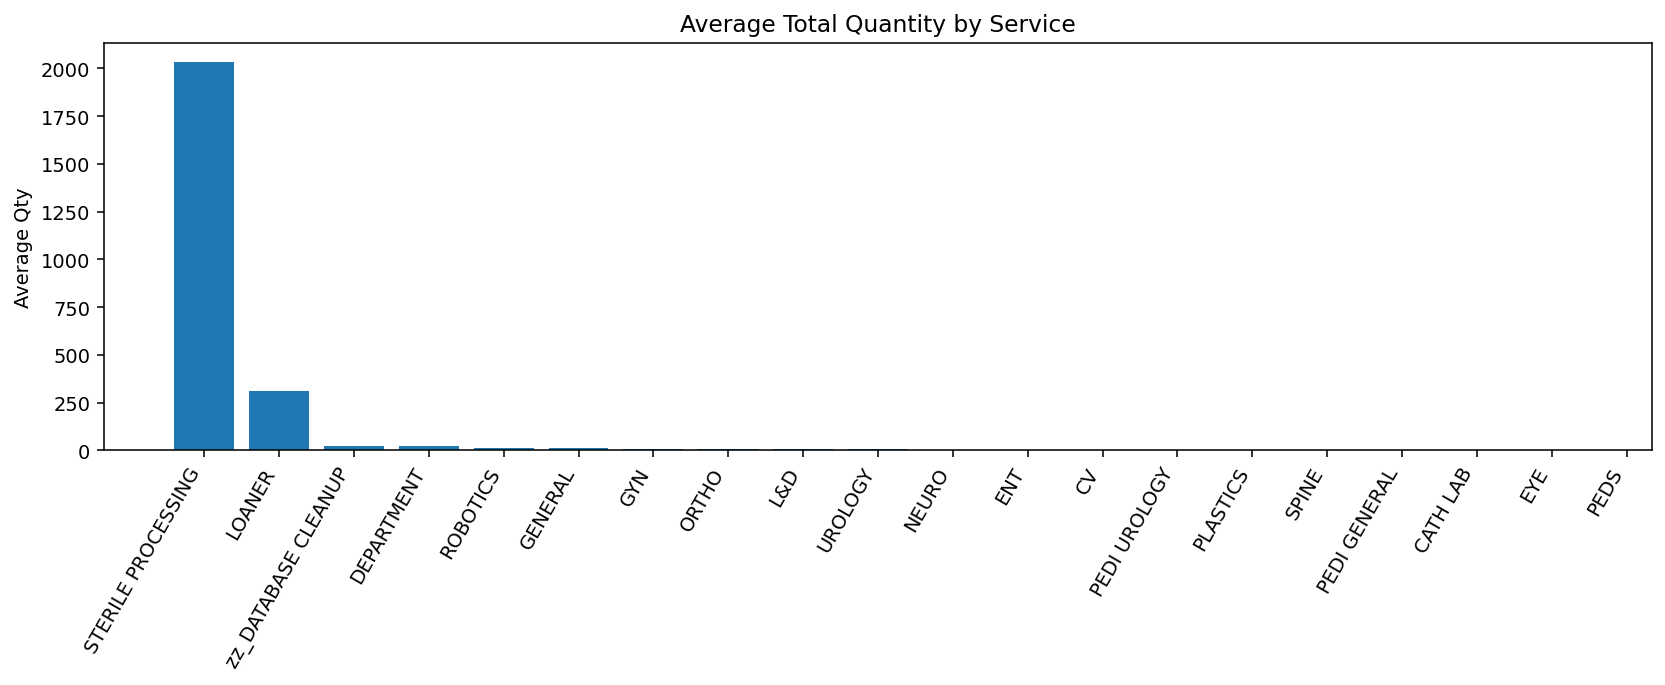

In [87]:
# Fill Rate and Qty by Service

import matplotlib.pyplot as plt

# Average qty per service (using PD_TotalQty if you have it)
svc_qty = (curated.groupBy("Service")
           .avg("PD_TotalQty")
           .orderBy(F.desc("avg(PD_TotalQty)")))

svc_pdf = svc_qty.toPandas()
plt.figure(figsize=(12,5))
plt.bar(svc_pdf["Service"], svc_pdf["avg(PD_TotalQty)"])
plt.xticks(rotation=60, ha="right")
plt.title("Average Total Quantity by Service")
plt.ylabel("Average Qty")
plt.tight_layout()
plt.show()

In [88]:
# Container Utilization and Event Rates
# Count sterilizations per container
ster_counts = (curated.groupBy("SerialKey")
               .agg(F.count("ST_SterilizedTs").alias("Sterilizations")))

# Join back to bridge for service context
ster_by_service = (ster_counts
    .join(inv_bridge.select("SerialKey","Service"), on="SerialKey", how="left")
    .groupBy("Service")
    .agg(F.avg("Sterilizations").alias("AvgSterilizations"))
    .orderBy(F.desc("AvgSterilizations"))
)
ster_by_service.show()

StatementMeta(, feee0914-270a-42af-9555-54386589a685, 90, Finished, Available, Finished)

+-------------------+-------------------+
|            Service|  AvgSterilizations|
+-------------------+-------------------+
|           CATH LAB|               97.0|
|                EYE|               55.0|
|       PEDI UROLOGY|              21.75|
|                 CV| 21.037037037037038|
|       PEDI GENERAL| 17.666666666666668|
|              SPINE| 14.761467889908257|
|                ENT| 12.797752808988765|
|              ORTHO| 12.354779411764707|
|         DEPARTMENT| 11.908045977011493|
|              NEURO| 11.790697674418604|
|           ROBOTICS| 10.959183673469388|
|           PLASTICS| 10.545454545454545|
|                GYN|  8.615384615384615|
|            GENERAL|  6.189830508474576|
|            UROLOGY|  5.387096774193548|
|                L&D|  2.230769230769231|
|             LOANER| 0.4558349451966473|
|zz_DATABASE CLEANUP|0.29545454545454547|
| STERILE PROCESSING|0.09836065573770492|
|               PEDS|                0.0|
+-------------------+-------------

In [89]:
# Missing Intruments Analysis 

missing_by_service = (curated.groupBy("Service")
                      .agg(F.sum("MI_QtyMissing").alias("TotalMissing")))
missing_by_service.orderBy(F.desc("TotalMissing")).show()

StatementMeta(, feee0914-270a-42af-9555-54386589a685, 91, Finished, Available, Finished)

+-------------------+------------+
|            Service|TotalMissing|
+-------------------+------------+
|              ORTHO|      6007.0|
|                ENT|       669.0|
|              SPINE|       626.0|
|           PLASTICS|       312.0|
|            GENERAL|       256.0|
|                 CV|       161.0|
|              NEURO|       146.0|
|           CATH LAB|        97.0|
|                EYE|        55.0|
|           ROBOTICS|        50.0|
|       PEDI UROLOGY|        39.0|
|         DEPARTMENT|        29.0|
|                GYN|        28.0|
|            UROLOGY|        14.0|
|             LOANER|        NULL|
| STERILE PROCESSING|        NULL|
|       PEDI GENERAL|        NULL|
|zz_DATABASE CLEANUP|        NULL|
|               PEDS|        NULL|
|                L&D|        NULL|
+-------------------+------------+



StatementMeta(, feee0914-270a-42af-9555-54386589a685, 92, Finished, Available, Finished)

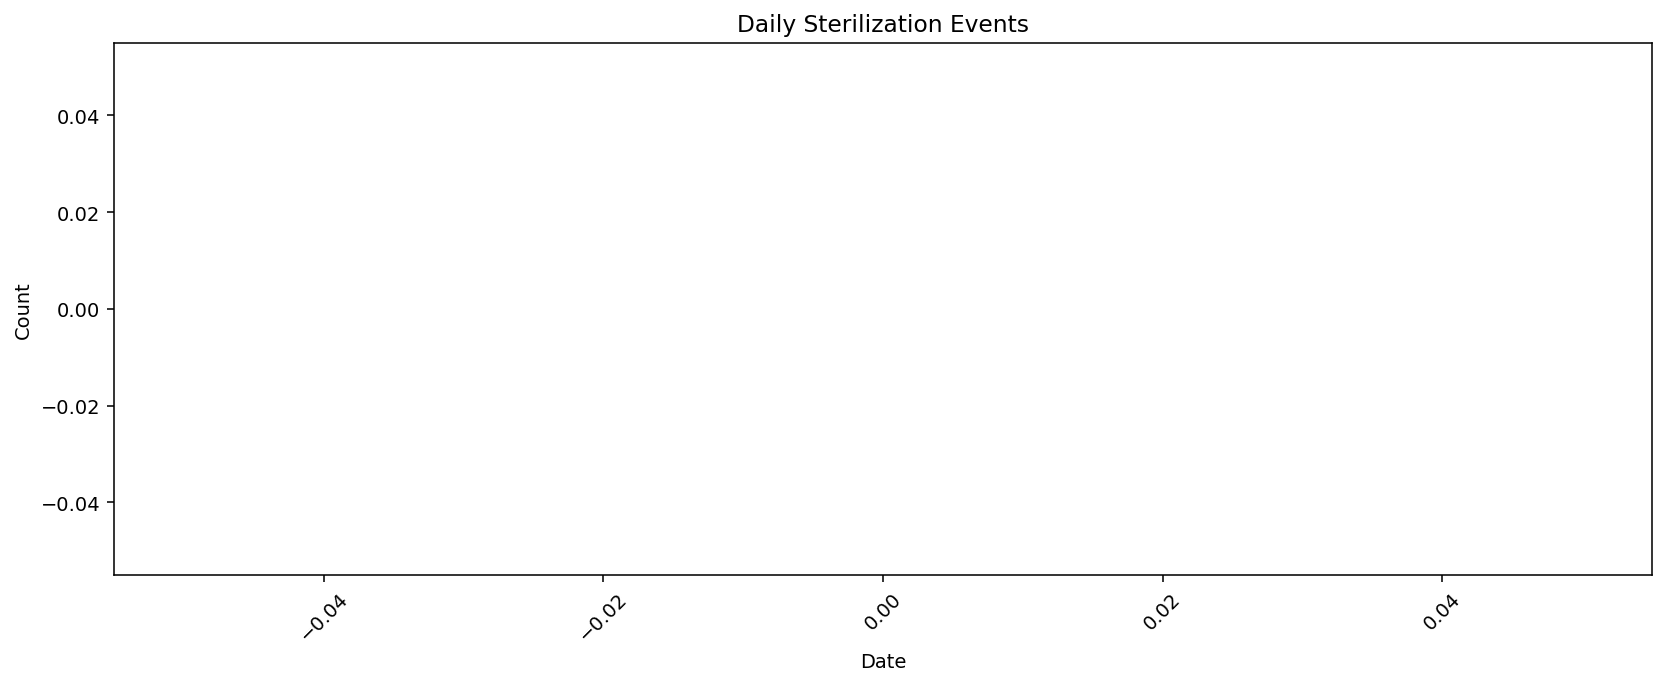

In [90]:
# Time Series Sterilization Trends

ster_trend = (curated
    .withColumn("SterDate", F.to_date("ST_SterilizedTs"))
    .groupBy("SterDate")
    .count()
    .orderBy("SterDate")
)

pdf = ster_trend.toPandas()
plt.figure(figsize=(12,5))
plt.plot(pdf["SterDate"], pdf["count"])
plt.title("Daily Sterilization Events")
plt.ylabel("Count")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

StatementMeta(, feee0914-270a-42af-9555-54386589a685, 93, Finished, Available, Finished)

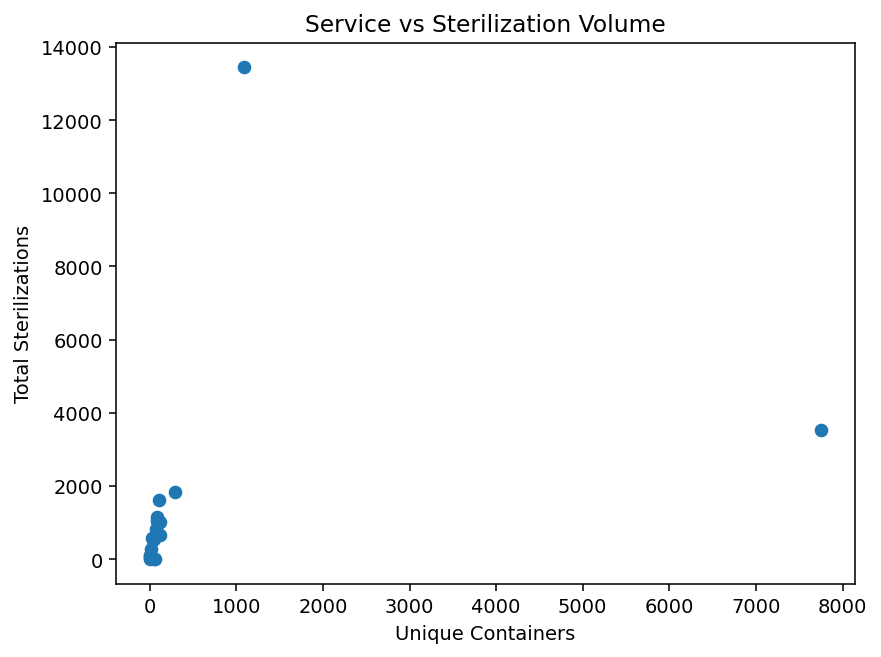

In [91]:
# Service vs. Times Sterilized Scatter Plot

svc_ster = (curated.groupBy("Service")
            .agg(F.count("ST_SterilizedTs").alias("TotalSterilizations"),
                 F.countDistinct("SerialKey").alias("UniqueContainers")))

svc_pdf = svc_ster.toPandas()
plt.scatter(svc_pdf["UniqueContainers"], svc_pdf["TotalSterilizations"])
plt.xlabel("Unique Containers")
plt.ylabel("Total Sterilizations")
plt.title("Service vs Sterilization Volume")
plt.tight_layout()
plt.show()

In [92]:
curated.select("ST_SterilizedTs").filter(F.col("ST_SterilizedTs").isNotNull()).count()

StatementMeta(, feee0914-270a-42af-9555-54386589a685, 94, Finished, Available, Finished)

27201

In [93]:
curated.select("ST_SterilizedTs").show(10, truncate=False)
print(curated.schema["ST_SterilizedTs"])

StatementMeta(, feee0914-270a-42af-9555-54386589a685, 95, Finished, Available, Finished)

+-------------------+
|ST_SterilizedTs    |
+-------------------+
|02/26/2025 22:43:40|
|NULL               |
|08/27/2025 17:12:11|
|08/27/2025 09:21:26|
|NULL               |
|08/28/2025 01:22:04|
|08/01/2025 15:49:21|
|04/14/2025 07:31:03|
|NULL               |
|NULL               |
+-------------------+
only showing top 10 rows

StructField('ST_SterilizedTs', StringType(), True)


In [94]:
from pyspark.sql import functions as F

# Try parsing with multiple patterns, fallback to string -> timestamp
curated_fixed = (curated
    .withColumn("SterDateParsed",
        F.coalesce(
            F.to_timestamp("ST_SterilizedTs", "MM/dd/yyyy HH:mm"),
            F.to_timestamp("ST_SterilizedTs", "MM/dd/yyyy hh:mm a"),
            F.to_timestamp("ST_SterilizedTs")  # last resort (Spark guess)
        )
    )
)

StatementMeta(, feee0914-270a-42af-9555-54386589a685, 96, Finished, Available, Finished)

In [95]:
from pyspark.sql import functions as F

# (optional) if your data is local-time
spark.conf.set("spark.sql.session.timeZone", "America/Chicago")

st_ts_raw = "Sterilized Date/Time"  # from your printout
st_clean = (st_keyed
    .select(
        "SerialKey",
        "ActualKey",
        F.trim(F.col(st_ts_raw)).alias("ST_raw")
    )
    # robust, regex-routed parsing (no exceptions)
    .withColumn(
        "ST_ts",
        F.when(F.col("ST_raw").rlike(r"^\d{2}/\d{2}/\d{4}\s+\d{2}:\d{2}:\d{2}$"),
               F.to_timestamp("ST_raw", "MM/dd/yyyy HH:mm:ss"))
         .when(F.col("ST_raw").rlike(r"^\d{2}/\d{2}/\d{4}\s+\d{2}:\d{2}$"),
               F.to_timestamp("ST_raw", "MM/dd/yyyy HH:mm"))
         .when(F.col("ST_raw").rlike(r"^\d{2}/\d{2}/\d{4}\s+\d{1,2}:\d{2}\s?[AP]M$"),
               F.to_timestamp("ST_raw", "MM/dd/yyyy hh:mm a"))
         .when(F.col("ST_raw").rlike(r"^\d{4}-\d{2}-\d{2}T?\d{2}:\d{2}:\d{2}"),
               F.to_timestamp("ST_raw", "yyyy-MM-dd'T'HH:mm:ss"))
         .when(F.col("ST_raw").rlike(r"^\d{4}-\d{2}-\d{2}$"),
               F.to_date("ST_raw").cast("timestamp"))
         .otherwise(F.to_timestamp("ST_raw"))  # last-resort guess
    )
)

# basic sanity
st_stats = st_clean.select(
    F.count(F.lit(1)).alias("rows"),
    F.sum(F.when(F.col("ST_ts").isNotNull(), 1).otherwise(0)).alias("parsed"),
    F.sum(F.when(F.col("SerialKey").isNotNull(), 1).otherwise(0)).alias("has_serial"),
    F.sum(F.when((F.col("SerialKey").isNotNull()) & (F.col("ST_ts").isNotNull()), 1).otherwise(0)).alias("both")
)
st_stats.show(truncate=False)

# daily trend (using parsed timestamps)
trend_daily = (st_clean
    .filter(F.col("ST_ts").isNotNull())
    .withColumn("SterDate", F.to_date("ST_ts"))
    .groupBy("SterDate")
    .count()
    .orderBy("SterDate")
)
trend_daily.show(10, truncate=False)

# if you specifically want only rows that also resolved to SerialKey:
trend_daily_serial = (st_clean
    .filter(F.col("ST_ts").isNotNull() & F.col("SerialKey").isNotNull())
    .withColumn("SterDate", F.to_date("ST_ts"))
    .groupBy("SterDate")
    .count()
    .orderBy("SterDate")
)
trend_daily_serial.show(10, truncate=False)


StatementMeta(, feee0914-270a-42af-9555-54386589a685, 97, Finished, Available, Finished)

+-----+------+----------+-----+
|rows |parsed|has_serial|both |
+-----+------+----------+-----+
|65150|65150 |60742     |60742|
+-----+------+----------+-----+

+----------+-----+
|SterDate  |count|
+----------+-----+
|2024-03-11|126  |
|2024-03-12|90   |
|2024-03-13|156  |
|2024-03-14|131  |
|2024-03-15|121  |
|2024-03-16|33   |
|2024-03-17|25   |
|2024-03-18|119  |
|2024-03-19|124  |
|2024-03-20|245  |
+----------+-----+
only showing top 10 rows

+----------+-----+
|SterDate  |count|
+----------+-----+
|2024-03-11|121  |
|2024-03-12|86   |
|2024-03-13|127  |
|2024-03-14|125  |
|2024-03-15|107  |
|2024-03-16|27   |
|2024-03-17|20   |
|2024-03-18|111  |
|2024-03-19|121  |
|2024-03-20|203  |
+----------+-----+
only showing top 10 rows



In [96]:
# SLA Scorecard

from pyspark.sql import functions as F, Window

# ---- Config (tweak as needed) ----
SLA_PASS_THRESHOLD = 0.995   # 99.5%
SLA_MIN_EVENTS     = 100
SLA_DAYS_LOOKBACK  = 30

spark.conf.set("spark.sql.session.timeZone", "America/Chicago")

# ---- Helpers ----
def pick_ci(cols, *opts):
    low = {c.lower(): c for c in cols}
    for o in opts:
        if o and o.lower() in low:
            return low[o.lower()]
    return None

def parse_ts_expr(col_name):
    c = F.col(col_name)
    return (F.when(c.rlike(r"^\d{2}/\d{2}/\d{4}\s+\d{2}:\d{2}:\d{2}$"),
                   F.to_timestamp(c, "MM/dd/yyyy HH:mm:ss"))
             .when(c.rlike(r"^\d{2}/\d{2}/\d{4}\s+\d{2}:\d{2}$"),
                   F.to_timestamp(c, "MM/dd/yyyy HH:mm"))
             .when(c.rlike(r"^\d{2}/\d{2}/\d{4}\s+\d{1,2}:\d{2}\s?[AP]M$"),
                   F.to_timestamp(c, "MM/dd/yyyy hh:mm a"))
             .when(c.rlike(r"^\d{4}-\d{2}-\d{2}T?\d{2}:\d{2}:\d{2}"),
                   F.to_timestamp(c, "yyyy-MM-dd'T'HH:mm:ss"))
             .when(c.rlike(r"^\d{4}-\d{2}-\d{2}$"),
                   F.to_date(c).cast("timestamp"))
             .otherwise(F.to_timestamp(c)))

# ---- 1) Ensure ST_ts exists on st_keyed ----
if "ST_ts" not in st_keyed.columns:
    ts_col = pick_ci(st_keyed.columns, "Sterilized Date/Time", "Start Time", "Timestamp", "Date", "Date/Time")
    assert ts_col, "No timestamp-like column found on st_keyed."
    st_keyed = st_keyed.withColumn("ST_ts", parse_ts_expr(ts_col))

# ---- 2) Ensure Service is present (join from inv_bridge on SerialKey if needed) ----
if "Service" not in st_keyed.columns:
    st_keyed = st_keyed.join(
        inv_bridge.select("SerialKey","Service").dropDuplicates(["SerialKey"]),
        on="SerialKey", how="left"
    )

# ---- 3) Build recent window & normalize Load Result ----
lr_col = pick_ci(st_keyed.columns, "Load Result","Result","Outcome")
assert lr_col, "Load Result-like column not found on st_keyed."

cutoff = F.date_sub(F.current_date(), SLA_DAYS_LOOKBACK)
st_recent = (st_keyed
    .filter(F.col("ST_ts").isNotNull())
    .withColumn("SterDate", F.to_date("ST_ts"))
    .filter(F.col("SterDate") >= cutoff)
)

st_recent = st_recent.withColumn(
    "pass",
    F.when(F.upper(F.col(lr_col)).like("%PASS%"), 1).otherwise(0)
)

# ---- 4) SLA scorecard ----
st_sla = (st_recent
    .groupBy("Service")
    .agg(
        F.count("*").alias("Events"),
        F.avg("pass").alias("PassRate")
    )
    .withColumn("MeetsSLA",
                (F.col("Events") >= F.lit(SLA_MIN_EVENTS)) &
                (F.col("PassRate") >= F.lit(SLA_PASS_THRESHOLD)))
    .orderBy(F.desc("MeetsSLA"), F.desc("PassRate"))
)

st_sla.show(50, truncate=False)


StatementMeta(, feee0914-270a-42af-9555-54386589a685, 98, Finished, Available, Finished)

+------------------+------+--------+--------+
|Service           |Events|PassRate|MeetsSLA|
+------------------+------+--------+--------+
|ROBOTICS          |4     |1.0     |false   |
|UROLOGY           |6     |1.0     |false   |
|DEPARTMENT        |15    |1.0     |false   |
|ORTHO             |10    |1.0     |false   |
|GENERAL           |9     |1.0     |false   |
|STERILE PROCESSING|17    |1.0     |false   |
|LOANER            |15    |1.0     |false   |
+------------------+------+--------+--------+



In [97]:
# Mean Time between Sterilizations in hours

from pyspark.sql import Window, functions as F

# compute inter-sterilization intervals per SerialKey
w = Window.partitionBy("SerialKey").orderBy(F.col("ST_ts").asc())
st_intervals = (st_keyed
    .filter(F.col("SerialKey").isNotNull() & F.col("ST_ts").isNotNull()))
st_intervals = (st_intervals
    .withColumn("prev_ts", F.lag("ST_ts").over(w))
    .withColumn("hours_between", F.when(F.col("prev_ts").isNotNull(), (F.col("ST_ts").cast("long") - F.col("prev_ts").cast("long"))/3600.0))
)

# MTBS per container (hours)
mtbs_per_serial = (st_intervals
    .groupBy("SerialKey")
    .agg(
        F.avg("hours_between").alias("MTBS_hours"),
        F.expr("percentile_approx(hours_between, 0.5)").alias("MTBS_med_hours"),
        F.count("*").alias("SterEvents")
    )
    .filter(F.col("SterEvents") >= 2)  # need at least 2 events to have an interval
)

# Join service and summarize
svc_view = inv_bridge.select("SerialKey","Service").dropDuplicates()
mtbs_by_service = (mtbs_per_serial
    .join(svc_view, "SerialKey", "left")
    .groupBy("Service")
    .agg(
        F.avg("MTBS_hours").alias("Avg_MTBS_h"),
        F.expr("percentile_approx(MTBS_hours, 0.5)").alias("Med_MTBS_h"),
        F.count("*").alias("Containers_count")
    )
    .orderBy(F.desc("Avg_MTBS_h"))
)

mtbs_by_service.show(30, truncate=False)


StatementMeta(, feee0914-270a-42af-9555-54386589a685, 99, Finished, Available, Finished)

+-------------------+------------------+------------------+----------------+
|Service            |Avg_MTBS_h        |Med_MTBS_h        |Containers_count|
+-------------------+------------------+------------------+----------------+
|PEDI GENERAL       |9675.227222222222 |9675.227222222222 |1               |
|PEDI UROLOGY       |6259.822548611111 |4105.724166666667 |8               |
|PLASTICS           |2631.7692697418724|1524.43           |49              |
|LOANER             |2243.5459198632075|1790.006388888889 |1289            |
|L&D                |1450.078611111111 |1450.078611111111 |1               |
|GYN                |1368.002687447446 |372.8397630718955 |74              |
|ORTHO              |1346.3534524928182|674.4311928104574 |530             |
|CATH LAB           |1298.0796759259263|1298.0796759259263|1               |
|SPINE              |1295.5564096096564|606.3857407407407 |78              |
|CV                 |1242.5577527474697|622.15487654321   |19              |

In [98]:
# Trend Anomalies

from pyspark.sql import functions as F

weekly = (st_keyed
    .filter(F.col("ST_ts").isNotNull())
    .withColumn("WeekStart", F.date_trunc("week", "ST_ts"))
    .groupBy("Service","WeekStart")
    .count()
)

# z-score per Service (deviations in weekly volume)
stats = (weekly.groupBy("Service")
    .agg(
        F.avg("count").alias("mu"),
        F.stddev_pop("count").alias("sigma")
    ))

weekly_z = (weekly.join(stats, "Service", "left")
    .withColumn("z", F.when(F.col("sigma")>0, (F.col("count")-F.col("mu"))/F.col("sigma")).otherwise(F.lit(0.0)))
    .withColumn("Anomaly", F.abs(F.col("z")) >= 2.5)  # tune threshold
    .orderBy(F.desc("Anomaly"), F.asc("WeekStart"))
)

weekly_z.show(40, truncate=False)

from pyspark.sql import functions as F, Window

# --- 1) Tidy + enrich anomaly table ---
anoms = (weekly_z
    # keep what we need
    .select(
        "Service",
        F.to_date("WeekStart").alias("Week"),
        F.col("count").alias("Events"),
        F.col("mu").alias("Baseline"),
        F.col("sigma").alias("StdDev"),
        F.col("z").alias("Z"),
        "Anomaly"
    )
    # computed fields
    .withColumn("Delta", F.col("Events") - F.col("Baseline"))
    .withColumn("PctChange", F.when(F.col("Baseline") > 0, F.col("Delta")/F.col("Baseline")).otherwise(F.lit(None)))
    .withColumn("Direction", F.when(F.col("Delta") >= 0, F.lit("UP")).otherwise(F.lit("DOWN")))
    .withColumn("AbsZ", F.abs(F.col("Z")))
    .withColumn(
        "Severity",
        F.when(F.col("AbsZ") >= 3.0, "HIGH")
         .when(F.col("AbsZ") >= 2.5, "MEDIUM")
         .otherwise("LOW")
    )
    # nice rounding
    .withColumn("Baseline", F.round("Baseline", 2))
    .withColumn("StdDev",   F.round("StdDev", 2))
    .withColumn("Z",        F.round("Z", 3))
    .withColumn("AbsZ",     F.round("AbsZ", 3))
    .withColumn("PctChange", F.round(F.col("PctChange")*100, 1))  # %
)

# Optional: filter to only meaningful anomalies and where variance exists
anoms_clean = (anoms
    .filter(F.col("StdDev").isNotNull() & (F.col("StdDev") > 0))
)

# --- 2) Overall TOP anomalies (by absolute Z) ---
top_overall = (anoms_clean
    .orderBy(F.desc("Anomaly"), F.desc("AbsZ"), F.desc("Week"))
)

# Show a tight list (tune the limit as you like)
top_overall.show(40, truncate=False)

# --- 3) Latest anomaly per Service (so the table isn’t spammy) ---
w_latest_anom = Window.partitionBy("Service").orderBy(F.col("Week").desc(), F.col("AbsZ").desc())
latest_per_service = (anoms_clean
    .filter(F.col("Anomaly") == True)
    .withColumn("rn", F.row_number().over(w_latest_anom))
    .filter(F.col("rn") == 1)
    .drop("rn")
    .orderBy(F.desc("AbsZ"))
)

latest_per_service.show(50, truncate=False)

# --- 4) (Optional) Rank anomalies within each Service for context ---
w_rank = Window.partitionBy("Service").orderBy(F.desc("AbsZ"))
ranked_by_service = (anoms_clean
    .withColumn("RankInService", F.row_number().over(w_rank))
    .orderBy("Service", F.asc("RankInService"), F.desc("Week"))
)

# If you want only the top N per Service:
N = 5
topN_per_service = ranked_by_service.filter(F.col("RankInService") <= N)
# topN_per_service.show(100, truncate=False)

# --- 5) (Optional) Save tidy views for BI/dashboard use ---
# spark.sql("CREATE DATABASE IF NOT EXISTS mh_sugarland")
# top_overall.write.mode("overwrite").format("delta").saveAsTable("mh_sugarland.kpi_anomalies_overall")
# latest_per_service.write.mode("overwrite").format("delta").saveAsTable("mh_sugarland.kpi_anomalies_latest_per_service")
# topN_per_service.write.mode("overwrite").format("delta").saveAsTable("mh_sugarland.kpi_anomalies_top5_per_service")


StatementMeta(, feee0914-270a-42af-9555-54386589a685, 100, Finished, Available, Finished)

+------------------+-------------------+-----+------------------+------------------+--------------------+-------+
|Service           |WeekStart          |count|mu                |sigma             |z                   |Anomaly|
+------------------+-------------------+-----+------------------+------------------+--------------------+-------+
|ORTHO             |2024-06-17 00:00:00|315  |178.0897435897436 |48.07317763188286 |2.847955204014961   |true   |
|LOANER            |2024-09-02 00:00:00|262  |135.82051282051282|47.11462933286127 |2.6781381699522395  |true   |
|DEPARTMENT        |2024-09-23 00:00:00|4    |63.26923076923077 |12.032725757361613|-4.925669541913219  |true   |
|GENERAL           |2024-11-18 00:00:00|276  |187.57692307692307|34.57934733807763 |2.557106589045085   |true   |
|ENT               |2024-12-09 00:00:00|25   |10.75             |5.047472009254784 |2.8231954479137156  |true   |
|CV                |2025-04-07 00:00:00|18   |7.24              |4.301441618806422 |2.50

In [99]:
# Containers with recurring missing items

from pyspark.sql import functions as F

mi_qty_col = next((c for c in ["Qty Missing","Quantity Missing","Missing Qty"] if c in mi_keyed.columns), None)
mi_item_col = next((c for c in ["Catalog Name","Item Name","Instrument Name"] if c in mi_keyed.columns), None)
assert mi_qty_col and mi_item_col, "Missing instruments columns not found on mi_keyed."

repeat_missing = (mi_keyed
    .filter(F.col(mi_qty_col).isNotNull() & (F.col(mi_qty_col) > 0) & F.col("SerialKey").isNotNull())
    .groupBy("SerialKey", mi_item_col)
    .agg(
        F.sum(F.col(mi_qty_col)).alias("TotalMissing"),
        F.count("*").alias("Occurrences")
    )
    .orderBy(F.desc("TotalMissing"), F.desc("Occurrences"))
)

repeat_missing.show(30, truncate=False)


StatementMeta(, feee0914-270a-42af-9555-54386589a685, 101, Finished, Available, Finished)

+---------+----------------------------------------------------------------------+------------+-----------+
|SerialKey|Catalog Name                                                          |TotalMissing|Occurrences|
+---------+----------------------------------------------------------------------+------------+-----------+
|11207000 |no countsheet                                                         |100.0       |1          |
|11169311 |K-WIRE DIAMETER 1.25 MM 150 MM                                        |10.0        |1          |
|10244816 |WIRE KIRSCHNER 1.25 X 150MM W/ TROCAR POINT                           |9.0         |1          |
|11169311 |K-WIRE DIAMETER 1.6 MM 150 MM                                         |6.0         |1          |
|11169311 |SCREW 3.5 X 18MM NL FULL-THREAD W/ T-10 HEAD (VARIAX)                 |6.0         |1          |
|10304406 |PIN 3.2 MM X 300 MM THREADED GUIDE                                    |6.0         |1          |
|10305841 |FEMORAL LUG TRIAL

In [100]:
#Heatmap table - weekday x hour (for staffing)

from pyspark.sql import functions as F

ster_heat = (st_keyed
    .filter(F.col("ST_ts").isNotNull())
    .withColumn("Dow", F.date_format("ST_ts", "E"))   # Mon..Sun
    .withColumn("Hour", F.hour("ST_ts"))
    .groupBy("Service","Dow","Hour")
    .count()
)

ster_heat.show(25, truncate=False)


StatementMeta(, feee0914-270a-42af-9555-54386589a685, 102, Finished, Available, Finished)

+------------------+---+----+-----+
|Service           |Dow|Hour|count|
+------------------+---+----+-----+
|LOANER            |Sat|4   |47   |
|STERILE PROCESSING|Sat|7   |45   |
|UROLOGY           |Fri|16  |56   |
|UROLOGY           |Wed|1   |9    |
|ORTHO             |Wed|1   |36   |
|ROBOTICS          |Sat|9   |12   |
|GENERAL           |Tue|15  |259  |
|GENERAL           |Tue|19  |225  |
|STERILE PROCESSING|Thu|4   |35   |
|GENERAL           |Tue|11  |127  |
|ROBOTICS          |Sat|5   |11   |
|GYN               |Sat|3   |4    |
|L&D               |Mon|15  |2    |
|UROLOGY           |Sat|9   |4    |
|ENT               |Wed|21  |11   |
|GYN               |Wed|21  |37   |
|STERILE PROCESSING|Mon|18  |36   |
|ORTHO             |Tue|7   |85   |
|GENERAL           |Tue|7   |43   |
|LOANER            |Wed|13  |88   |
|GENERAL           |Thu|6   |101  |
|DEPARTMENT        |Wed|7   |33   |
|SPINE             |Tue|14  |19   |
|ENT               |Wed|15  |57   |
|STERILE PROCESSING|Thu|15  

In [101]:
from pyspark.sql import functions as F

# Create a composite column for pivoting
ster_heat = (st_keyed
    .filter(F.col("ST_ts").isNotNull())
    .withColumn("Dow", F.date_format("ST_ts", "E"))   # Mon..Sun
    .withColumn("Hour", F.hour("ST_ts"))
    .withColumn("DowHour", F.concat_ws("_", "Dow", F.col("Hour")))
    .groupBy("Service", "DowHour")
    .count()
)

# Pivot to wide format: rows = Service, columns = DowHour
pivoted = ster_heat.groupBy("Service").pivot("DowHour").agg(F.first("count"))


StatementMeta(, feee0914-270a-42af-9555-54386589a685, 103, Finished, Available, Finished)

In [102]:
# Convert to Pandas
pivoted_pd = pivoted.toPandas().set_index("Service")

# Fill nulls with 0 (or use mean imputation if preferred)
pivoted_pd = pivoted_pd.fillna(0)

# Compute correlation matrix
corr_matrix = pivoted_pd.corr()


StatementMeta(, feee0914-270a-42af-9555-54386589a685, 104, Finished, Available, Finished)

StatementMeta(, feee0914-270a-42af-9555-54386589a685, 105, Finished, Available, Finished)

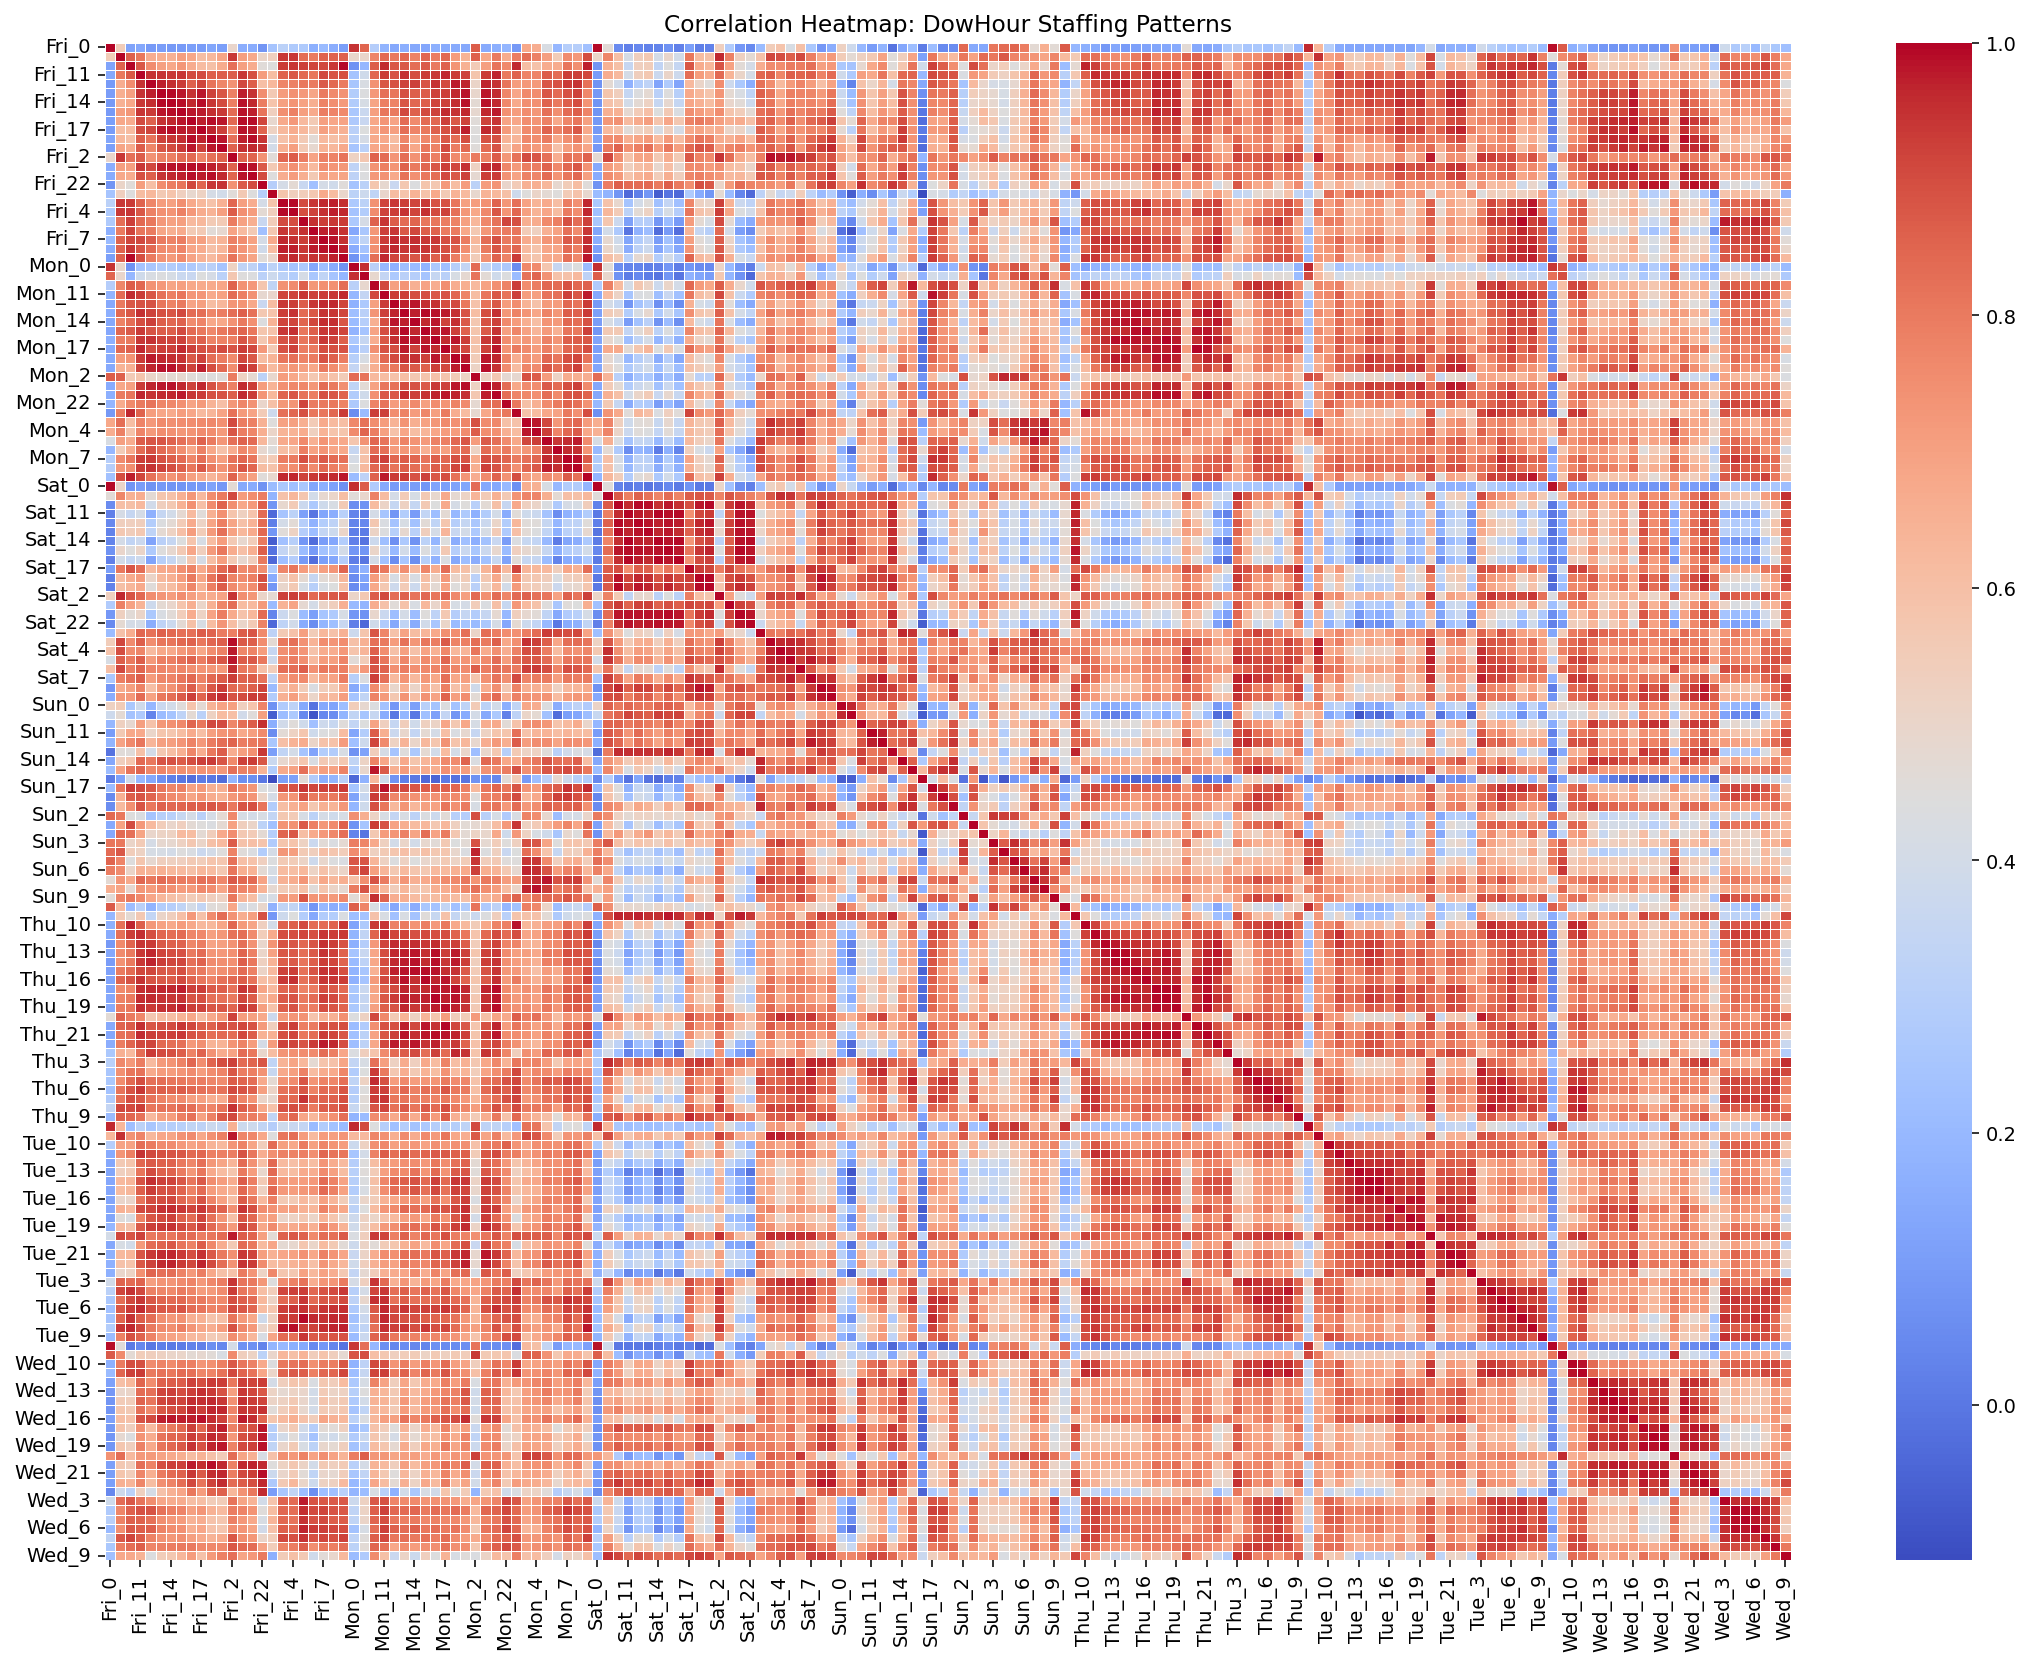

In [103]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=False, linewidths=0.5)
plt.title("Correlation Heatmap: DowHour Staffing Patterns")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [104]:
# Scorecards 
# 1) Create a simple, space-free schema
spark.sql("CREATE DATABASE IF NOT EXISTS `mh_sugarland`")

# 2) Save tables there (use backticks to avoid quoting issues)
st_sla.write.mode("overwrite").format("delta").saveAsTable("`mh_sugarland`.`kpi_sla_service_30d`")
mtbs_by_service.write.mode("overwrite").format("delta").saveAsTable("`mh_sugarland`.`kpi_mtbs_by_service`")
weekly_z.write.mode("overwrite").format("delta").saveAsTable("`mh_sugarland`.`kpi_weekly_volume_z`")
latest_per_service.write.mode("overwrite").format("delta").saveAsTable("`mh_sugarland`.`kpi_anomalies_latest_per_service`")

StatementMeta(, feee0914-270a-42af-9555-54386589a685, 106, Finished, Available, Finished)

In [105]:
import matplotlib.pyplot as plt

def line_from_df(df, x, y, title):
    pdf = df.toPandas()
    pdf = spark_df.select("WeekStart", "count").filter("Service = 'ORTHO'").toPandas()
    plt.figure(figsize=(10,4))
    plt.plot(pdf[x], pdf[y], marker="o")
    plt.title(title); plt.xticks(rotation=45); plt.tight_layout(); plt.show()

def bar_from_df(df, x, y, title):
    pdf = df.toPandas()
    pdf = spark_df.select("WeekStart", "count").filter("Service = 'ORTHO'").toPandas()
    plt.figure(figsize=(10,4))
    plt.bar(pdf[x].astype(str), pdf[y])
    plt.title(title); plt.xticks(rotation=60, ha="right"); plt.tight_layout(); plt.show()

# Examples:
#line_from_df(weekly_z.filter("Service = 'ORTHO'"), "WeekStart", "count", "ORTHO Weekly Sterilizations")
#bar_from_df(st_sla, "Service", "PassRate", "Pass Rate by Service (30d)")


StatementMeta(, feee0914-270a-42af-9555-54386589a685, 107, Finished, Available, Finished)

In [106]:
from pyspark.sql import functions as F, Window

# Start from your existing weekly_z (Service, WeekStart, count, mu, sigma, z, Anomaly)
anoms = (weekly_z
    .select(
        "Service",
        F.to_date("WeekStart").alias("Week"),
        F.col("count").alias("Events"),
        F.col("mu").alias("Baseline"),
        F.col("sigma").alias("StdDev"),
        F.col("z").alias("Z"),
        "Anomaly"
    )
    .withColumn("Delta", F.col("Events") - F.col("Baseline"))
    .withColumn("PctChange", F.when(F.col("Baseline") > 0, F.col("Delta")/F.col("Baseline")))
    .withColumn("Direction", F.when(F.col("Delta") >= 0, F.lit("UP")).otherwise(F.lit("DOWN")))
    .withColumn("AbsZ", F.abs(F.col("Z")))
    # round numeric fields
    .withColumn("Baseline",  F.round("Baseline", 2))
    .withColumn("StdDev",    F.round("StdDev", 2))
    .withColumn("Z",         F.round("Z", 3))
    .withColumn("AbsZ",      F.round("AbsZ", 3))
    .withColumn("PctChange", F.round(F.col("PctChange")*100, 1))  # to %
)

# Keep only rows with usable variance
anoms_clean = anoms.filter((F.col("StdDev").isNotNull()) & (F.col("StdDev") > 0))


StatementMeta(, feee0914-270a-42af-9555-54386589a685, 108, Finished, Available, Finished)

In [107]:
top_overall = (anoms_clean
    .orderBy(F.desc("Anomaly"), F.desc("AbsZ"), F.desc("Week"))
    .select(
        "Service", "Week",
        "Events", "Baseline", "Delta",
        F.col("PctChange").alias("%Δ"),
        F.col("Z").alias("Z-score"),
        "Anomaly", "Direction"
    )
)

display(top_overall.limit(50))


StatementMeta(, feee0914-270a-42af-9555-54386589a685, 109, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, ce60773d-cb98-4869-a8d4-9291a068e8fe)

In [108]:
w_latest = Window.partitionBy("Service").orderBy(F.col("Week").desc(), F.col("AbsZ").desc())

latest_per_service = (anoms_clean
    .filter(F.col("Anomaly") == True)
    .withColumn("rn", F.row_number().over(w_latest))
    .filter("rn = 1")
    .drop("rn")
    .orderBy(F.desc("AbsZ"))
    .select(
        "Service", "Week",
        "Events", "Baseline", "Delta",
        F.col("PctChange").alias("%Δ"),
        F.col("Z").alias("Z-score"),
        "Direction"
    )
)

display(latest_per_service)


StatementMeta(, feee0914-270a-42af-9555-54386589a685, 110, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 6c5700b4-d985-4675-a355-fd92c48db16d)

In [109]:
N = 3  # change to 5 if you want more per service
w_rank = Window.partitionBy("Service").orderBy(F.desc("AbsZ"), F.desc("Week"))

topN_per_service = (anoms_clean
    .withColumn("Rank", F.row_number().over(w_rank))
    .filter(F.col("Rank") <= N)
    .orderBy("Service", "Rank", F.desc("Week"))
    .select(
        "Service", "Week", "Rank",
        "Events", "Baseline", "Delta",
        F.col("PctChange").alias("%Δ"),
        F.col("Z").alias("Z-score"),
        "Direction"
    )
)

display(topN_per_service)


StatementMeta(, feee0914-270a-42af-9555-54386589a685, 111, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, d63f730c-8623-4e3b-90cf-4923deb48119)

StatementMeta(, feee0914-270a-42af-9555-54386589a685, 112, Finished, Available, Finished)

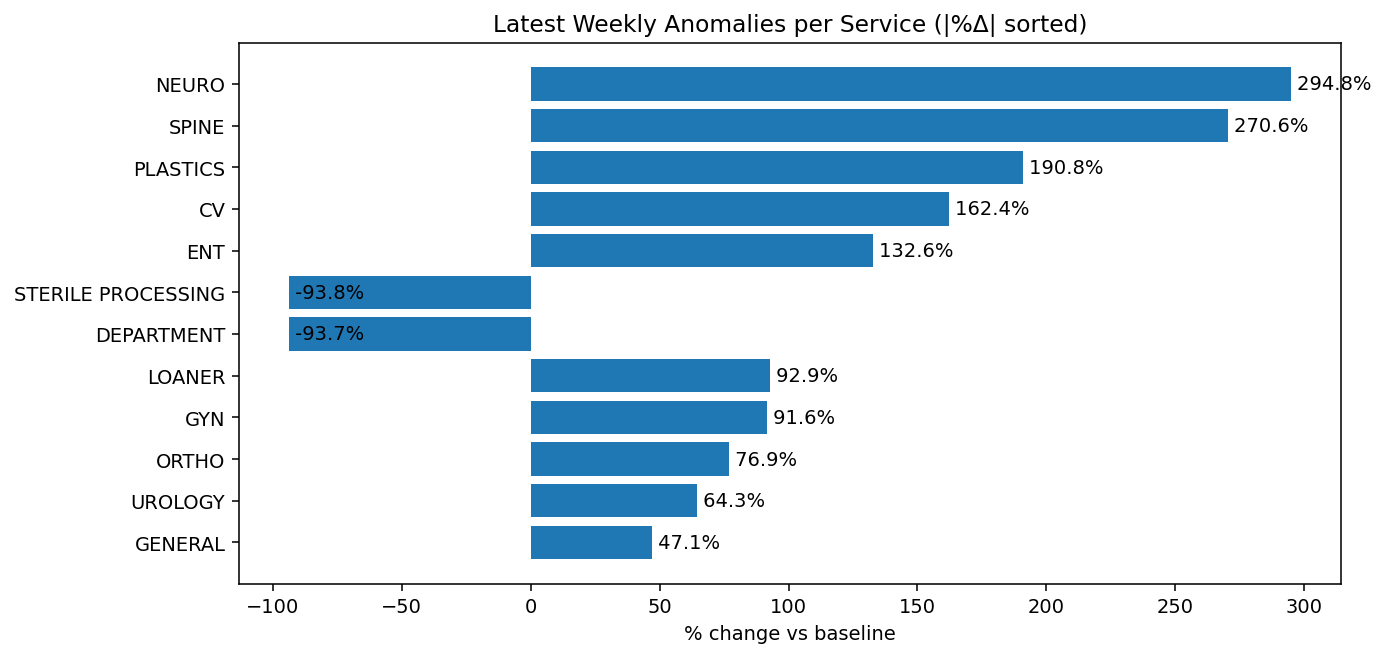

In [110]:
# Requires: latest_per_service with columns: Service, %Δ, Direction
import matplotlib.pyplot as plt

# Convert to pandas for plotting
lp = latest_per_service.toPandas().copy()

# If %Δ came in as string/Decimal, coerce safely
lp["%Δ"] = pd.to_numeric(lp["%Δ"], errors="coerce")

# Sort by absolute %Δ so the biggest moves are on top
lp = lp.sort_values("%Δ", key=lambda s: s.abs(), ascending=True)

# Build labels: show week and direction too (optional)
labels = lp["Service"].astype(str).tolist()
values = lp["%Δ"].values

plt.figure(figsize=(10, max(4, 0.4*len(labels))))  # auto height by rows
plt.barh(labels, values)  # default matplotlib colors (Fabric-safe rule)
plt.xlabel("% change vs baseline")
plt.title("Latest Weekly Anomalies per Service (|%Δ| sorted)")
# Annotate bars with % values
for i, v in enumerate(values):
    plt.text(v, i, f" {v:.1f}%", va="center")

plt.tight_layout()
plt.show()


StatementMeta(, feee0914-270a-42af-9555-54386589a685, 113, Finished, Available, Finished)

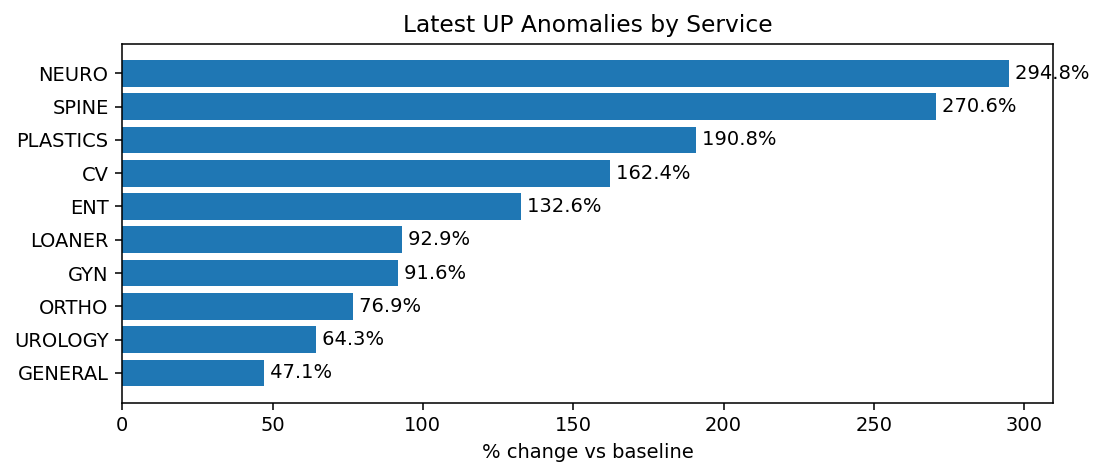

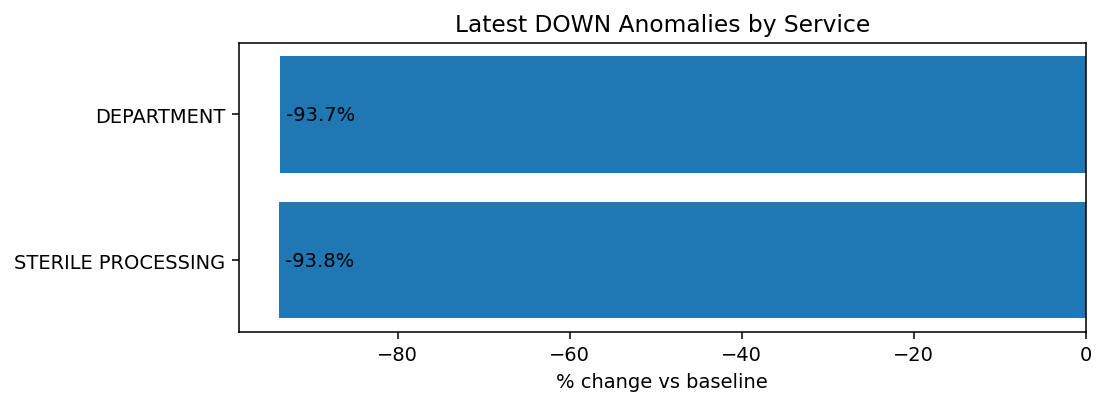

In [111]:
# UP only
lp_up = latest_per_service.filter("`%Δ` > 0").toPandas().copy()
lp_up["%Δ"] = pd.to_numeric(lp_up["%Δ"], errors="coerce")
lp_up = lp_up.sort_values("%Δ", ascending=True)

plt.figure(figsize=(8, max(3, 0.35*len(lp_up))))
plt.barh(lp_up["Service"].astype(str), lp_up["%Δ"].values)
plt.xlabel("% change vs baseline")
plt.title("Latest UP Anomalies by Service")
for i, v in enumerate(lp_up["%Δ"].values):
    plt.text(v, i, f" {v:.1f}%", va="center")
plt.tight_layout(); plt.show()

# DOWN only
lp_dn = latest_per_service.filter("`%Δ` < 0").toPandas().copy()
lp_dn["%Δ"] = pd.to_numeric(lp_dn["%Δ"], errors="coerce")
lp_dn = lp_dn.sort_values("%Δ", ascending=True)  # more negative at top

plt.figure(figsize=(8, max(3, 0.35*len(lp_dn))))
plt.barh(lp_dn["Service"].astype(str), lp_dn["%Δ"].values)
plt.xlabel("% change vs baseline")
plt.title("Latest DOWN Anomalies by Service")
for i, v in enumerate(lp_dn["%Δ"].values):
    plt.text(v, i, f" {v:.1f}%", va="center")
plt.tight_layout(); plt.show()


In [112]:
weekly_z.select("WeekStart", F.date_format("WeekStart","E").alias("Dow")).limit(5).show()
weekly_z.select(F.countDistinct(F.date_format("WeekStart","E"))).show()  # likely 1 (Mon)


StatementMeta(, feee0914-270a-42af-9555-54386589a685, 114, Finished, Available, Finished)

+-------------------+---+
|          WeekStart|Dow|
+-------------------+---+
|2024-06-17 00:00:00|Mon|
|2024-09-02 00:00:00|Mon|
|2024-09-23 00:00:00|Mon|
|2024-11-18 00:00:00|Mon|
|2024-12-09 00:00:00|Mon|
+-------------------+---+

+-----------------------------------------+
|count(DISTINCT date_format(WeekStart, E))|
+-----------------------------------------+
|                                        1|
+-----------------------------------------+



In [113]:
from pyspark.sql import functions as F

# Build tidy anomaly frame
anoms = (weekly_z
    .withColumn("Week", F.to_date("WeekStart"))
    .withColumn("Dow", F.date_format("Week", "E"))   # Mon, Tue, ...
    .withColumn("AbsZ", F.abs(F.col("z")))
    .filter(F.col("Anomaly") == True)
    .select("Service","Week","Dow","AbsZ")
)

# Pivot to Service x Weekday (counts)
wkday_pivot = (anoms
    .groupBy("Service")
    .pivot("Dow", ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"])
    .count()
    .na.fill(0)
    .orderBy("Service")
)

display(wkday_pivot)


StatementMeta(, feee0914-270a-42af-9555-54386589a685, 115, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 53f42818-9cf6-45e9-b76b-f544d661e8c3)

In [114]:
df = spark.sql("SELECT * FROM MemorialHermann.mh_sugarland.kpi_anomalies_latest_per_service LIMIT 1000")
display(df)

StatementMeta(, feee0914-270a-42af-9555-54386589a685, 116, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, a819984c-c8d2-42c1-9323-931d3a70b593)

StatementMeta(, feee0914-270a-42af-9555-54386589a685, 117, Finished, Available, Finished)

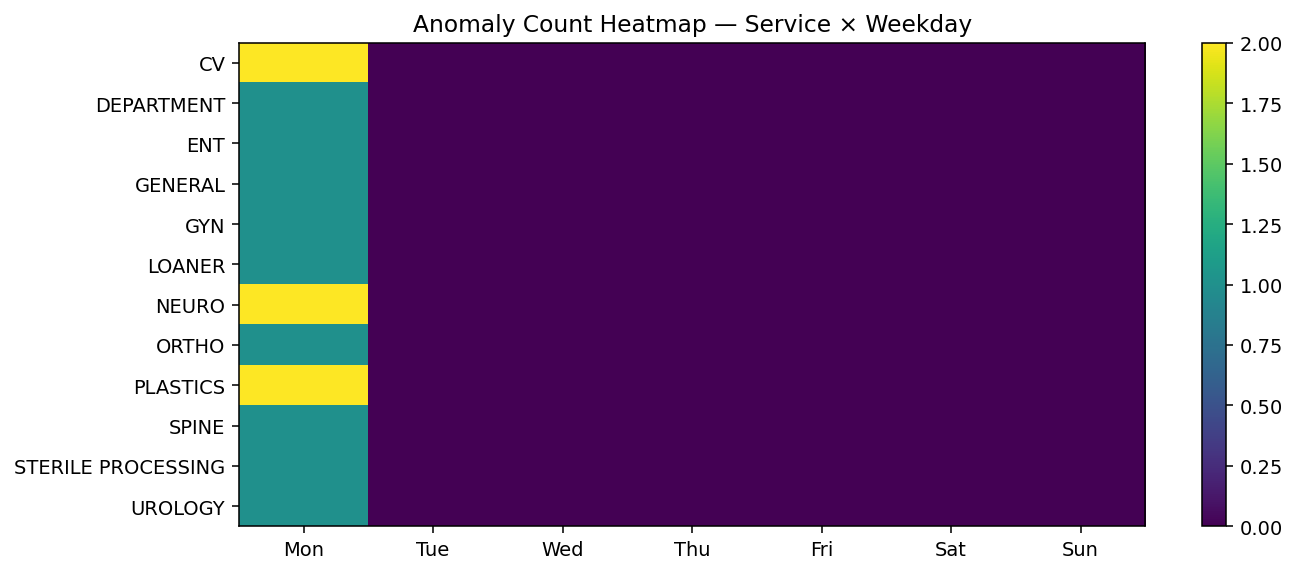

In [115]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

pdf = wkday_pivot.toPandas().set_index("Service")
data = pdf[["Mon","Tue","Wed","Thu","Fri","Sat","Sun"]].values.astype(float)

plt.figure(figsize=(10, max(4, 0.35*len(pdf))))
plt.imshow(data, aspect="auto")
plt.xticks(range(7), ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"])
plt.yticks(range(len(pdf.index)), pdf.index)
plt.title("Anomaly Count Heatmap — Service × Weekday")
plt.colorbar()
plt.tight_layout()
plt.show()


In [116]:
from pyspark.sql import functions as F

# Add month key like 2025-09
anoms_month = (weekly_z
    .withColumn("Month", F.date_format("WeekStart", "yyyy-MM"))
    .withColumn("AbsZ", F.abs(F.col("z")))
    .filter(F.col("Anomaly") == True)
    .select("Service","Month","AbsZ")
)

# Pivot to Service x Month — average AbsZ (anomaly intensity)
mon_pivot = (anoms_month
    .groupBy("Service")
    .pivot("Month")
    .avg("AbsZ")
    .orderBy("Service")
)

display(mon_pivot)


StatementMeta(, feee0914-270a-42af-9555-54386589a685, 118, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, cff9a324-582d-405b-8ae8-f9c364747f62)

StatementMeta(, feee0914-270a-42af-9555-54386589a685, 119, Finished, Available, Finished)

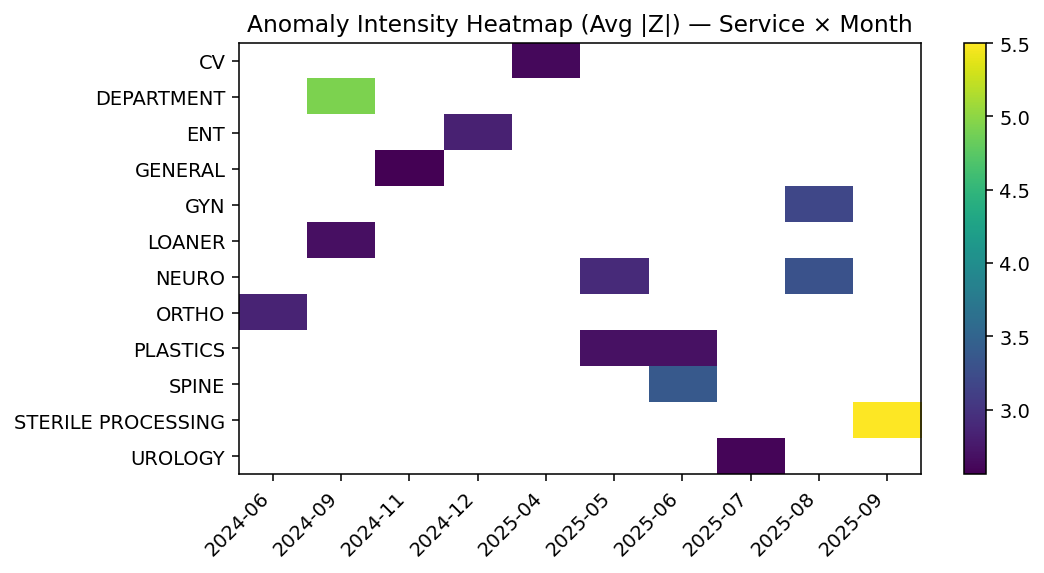

In [117]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

mpdf = mon_pivot.toPandas().set_index("Service")
# ensure months are sorted chronologically
mpdf = mpdf.reindex(sorted(mpdf.columns), axis=1)
data = mpdf.values.astype(float)

plt.figure(figsize=(max(8, 0.5*len(mpdf.columns)), max(4, 0.35*len(mpdf))))
plt.imshow(data, aspect="auto")
plt.xticks(range(len(mpdf.columns)), mpdf.columns, rotation=45, ha="right")
plt.yticks(range(len(mpdf.index)), mpdf.index)
plt.title("Anomaly Intensity Heatmap (Avg |Z|) — Service × Month")
plt.colorbar()
plt.tight_layout()
plt.show()


In [118]:
from pyspark.sql import functions as F
wk = (st_keyed.withColumn("Week", F.date_trunc("week","ST_ts"))
      .withColumn("pass", F.when(F.upper(F.col("Load Result")).like("%PASS%"),1).otherwise(0))
      .groupBy("Service","Week").agg(F.avg("pass").alias("PassRate"), F.count("*").alias("N")))
svc_stats = wk.groupBy("Service").agg(F.avg("PassRate").alias("pbar"))
pchart = (wk.join(svc_stats,"Service")
            .withColumn("SE", F.sqrt(F.col("pbar")*(1-F.col("pbar"))/F.col("N")))
            .withColumn("UCL", F.col("pbar")+3*F.col("SE"))
            .withColumn("LCL", F.greatest(F.lit(0.0), F.col("pbar")-3*F.col("SE"))))


StatementMeta(, feee0914-270a-42af-9555-54386589a685, 120, Finished, Available, Finished)

In [119]:
alpha = 0.2
from pyspark.sql import Window, functions as F
w = Window.partitionBy("Service").orderBy("Week")
wk_sorted = wk.orderBy("Service","Week")
# recursive EWMA via cumulative formula
ewma = (wk_sorted
        .withColumn("one_minus_a_pow_k", (1 - F.lit(alpha)) ** (F.row_number().over(w)-1))
        .withColumn("term", F.col("PassRate") * alpha * (1 - F.lit(alpha)) ** (F.row_number().over(w)-1))
        .withColumn("EWMA", F.sum("term").over(w) / (1 - F.col("one_minus_a_pow_k"))))


StatementMeta(, feee0914-270a-42af-9555-54386589a685, 121, Finished, Available, Finished)

In [120]:
from pyspark.sql import Window, functions as F
w = Window.partitionBy("SerialKey").orderBy("ST_ts")
reproc = (st_keyed
          .withColumn("prev", F.lag("ST_ts").over(w))
          .withColumn("hrs", (F.col("ST_ts").cast("long")-F.col("prev").cast("long"))/3600)
          .withColumn("is_rerun", F.col("hrs")<=24)
          .groupBy("Service").agg(F.avg(F.col("is_rerun").cast("double")).alias("RerunRate_24h")))


StatementMeta(, feee0914-270a-42af-9555-54386589a685, 122, Finished, Available, Finished)

In [121]:
from pyspark.sql import functions as F

def profile_df(df, name, topn=10):
    print(f"\n=== PROFILE: {name} ===")
    print(f"Row count: {df.count()}, Column count: {len(df.columns)}")

    # Missing value % per column
    miss = (df.select([
        (F.count(F.when(F.col(c).isNull() | (F.col(c) == ""), c)) / F.count("*"))
        .alias(c) for c in df.columns
    ])).toPandas().T.reset_index()
    miss.columns = ["Column","MissingPct"]
    display(miss.sort_values("MissingPct", ascending=False))

    # Top N value counts for each column (categorical only)
    for c in df.columns:
        distinct_ct = df.select(c).distinct().count()
        if distinct_ct <= 50:  # only profile "small-cardinality" columns
            top_values = (df.groupBy(c).count()
                           .orderBy(F.desc("count"))
                           .limit(topn))
            print(f"\nTop {topn} values for {c} (Distinct={distinct_ct}):")
            display(top_values)

# ---- Run profiling for all 5 datasets ----
profile_df(df,  "Container — General Info")
profile_df(df2, "Container — Inventory by Location")
profile_df(df3, "Container — Product Detail")
profile_df(df4, "Instrument — Missing Items")
profile_df(df5, "Sterilization — Container Level")


StatementMeta(, feee0914-270a-42af-9555-54386589a685, 123, Finished, Available, Finished)


=== PROFILE: Container — General Info ===
Row count: 12, Column count: 12


SynapseWidget(Synapse.DataFrame, 824dfe3a-4ac1-41e9-88c6-ad25722a0522)


Top 10 values for Service (Distinct=12):


SynapseWidget(Synapse.DataFrame, aa17aefa-f9bd-4d1f-9b10-92f97a3da30f)


Top 10 values for Week (Distinct=11):


SynapseWidget(Synapse.DataFrame, 3a9deb33-e8f2-4dd1-9a0a-66dcea799ce7)


Top 10 values for Events (Distinct=10):


SynapseWidget(Synapse.DataFrame, b48b1141-2146-4ec9-86a8-8a2aef3691b1)


Top 10 values for Baseline (Distinct=12):


SynapseWidget(Synapse.DataFrame, aa33f7fb-954a-4894-9c7a-4e337e04ea15)


Top 10 values for StdDev (Distinct=12):


SynapseWidget(Synapse.DataFrame, ba27935c-9995-4ecb-8d4c-30803e114ae4)


Top 10 values for Z (Distinct=12):


SynapseWidget(Synapse.DataFrame, 60f4df19-ae28-40c0-982f-2dab988ebcfa)


Top 10 values for Anomaly (Distinct=1):


SynapseWidget(Synapse.DataFrame, c8e0ecd4-15f0-47cd-80e0-d17ee617ac7a)


Top 10 values for Delta (Distinct=12):


SynapseWidget(Synapse.DataFrame, adf17fa9-28f2-4826-aae7-491ea312c128)


Top 10 values for PctChange (Distinct=12):


SynapseWidget(Synapse.DataFrame, 282fa6b8-9ef0-48d8-816b-de748497f890)


Top 10 values for Direction (Distinct=2):


SynapseWidget(Synapse.DataFrame, 0539cec3-8e20-4fcc-87db-d1eae85f764e)


Top 10 values for AbsZ (Distinct=12):


SynapseWidget(Synapse.DataFrame, 2849152c-d652-4237-888f-a6c735980f3f)


Top 10 values for Severity (Distinct=2):


SynapseWidget(Synapse.DataFrame, 5abc2d07-b7a8-4759-8e38-57ba56896825)


=== PROFILE: Container — Inventory by Location ===
Row count: 9996, Column count: 11


SynapseWidget(Synapse.DataFrame, c2afdbbc-4d28-470a-8ade-180b929d0cf5)


Top 10 values for Facility (Distinct=1):


SynapseWidget(Synapse.DataFrame, 1b54432c-745d-4ddc-90c4-fd5525d99143)


Top 10 values for Service (Distinct=20):


SynapseWidget(Synapse.DataFrame, 5930b408-0963-41c5-b942-3f637fd42c3d)


Top 10 values for Tally (Distinct=1):


SynapseWidget(Synapse.DataFrame, 3198d6dd-5438-4f02-b962-41ab0913a9e1)


Top 10 values for Container Status (Distinct=6):


SynapseWidget(Synapse.DataFrame, 3a5af466-c3de-44ea-a81c-797d9e66053f)


=== PROFILE: Container — Product Detail ===
Row count: 16444, Column count: 15


AnalysisException: Syntax error in attribute name: Qty..

In [ ]:
from pyspark.sql import functions as F, types as T

def q(c: str):
    # Quote any column safely, including dots/spaces
    return F.col(f"`{c}`")

def profile_df(df, name, topn=10, small_card_threshold=50):
    print(f"\n=== PROFILE: {name} ===")
    print(f"Row count: {df.count()}, Column count: {len(df.columns)}")

    # Build missing% per column (nulls + empty strings for string-typed columns)
    schema_map = {f.name: f.dataType for f in df.schema.fields}

    miss_exprs = []
    for c in df.columns:
        is_null = q(c).isNull()
        is_blank = F.lit(False)
        if isinstance(schema_map.get(c), T.StringType):
            is_blank = (F.length(F.trim(q(c))) == 0)
        miss_exprs.append((F.avg((is_null | is_blank).cast("double")).alias(c)))

    miss = df.select(miss_exprs)
    miss_pdf = miss.toPandas().T.reset_index()
    miss_pdf.columns = ["Column", "MissingPct"]
    # Show highest missing first
    display(miss_pdf.sort_values("MissingPct", ascending=False))

    # Top N value counts for small-cardinality columns
    for c in df.columns:
        try:
            distinct_ct = df.select(q(c)).distinct().count()
            if distinct_ct <= small_card_threshold:
                top_values = (df.groupBy(q(c)).count()
                                .orderBy(F.desc("count"))
                                .limit(topn))
                print(f"\nTop {topn} values for {c} (Distinct={distinct_ct}):")
                display(top_values)
        except Exception as e:
            print(f"[WARN] Skipping value profile for column '{c}': {e}")


StatementMeta(, feee0914-270a-42af-9555-54386589a685, -1, Cancelled, , Cancelled)